In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import tensorflow.compat.v1 as tf
import tensorflow.compat.v2 as tf2
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

### Read data from csv...

In [2]:
raw_x = []
raw_y = []
# Reading CSV data...
with open("maize_major_yield.csv", 'r', newline='') as file:
    rows = csv.reader(file)
    header = next(rows)
    for row in rows:
        raw_x.append(row[:-1])
        raw_y.append(row[-1])
        
# Convert to numpy arrays...
raw_x = np.array(raw_x).astype(np.float64)
raw_y = np.array(raw_y).astype(np.float64)

## Data exploration...
### Summary statistics...

In [3]:
print('{} features and the crop yield'.format(len(header[:-1])))
print('{} exemplars'.format(len(raw_x)))
print('\nList of features and their summary statistics:')
print('='*30,'', '='*6,'', '='*6)
print(' '*30, '  Min     Max')
print('='*30,'','='*6,'', '='*6)
mins = raw_x.min(axis=0)
maxs = raw_x.max(axis=0)
for col, feature in enumerate(header[:-1]):
    print('-> {}:'.format(feature), ' '*(26-len(feature)), \
         mins[col], ' '*(6-len(str(mins[col]))), maxs[col])
print('\nY:', raw_y.min(), raw_y.max(), raw_y.mean(), raw_y.std())

37 features and the crop yield
31744 exemplars

List of features and their summary statistics:
==============================  ======  ======
                                 Min     Max
==============================  ======  ======
-> year:                        1983.0  2013.0
-> jan rain:                    0.0     3476.0
-> jan mean min temperature:    -41.2   32.4
-> jan mean max temperature:    -23.8   40.2
-> feb rain:                    0.0     1009.0
-> feb mean min temperature:    -38.1   32.9
-> feb mean max temperature:    -18.8   46.5
-> mar rain:                    0.0     1102.4
-> mar mean min temperature:    -34.4   85.2
-> mar mean max temperature:    -11.3   42.0
-> apr rain:                    0.0     1687.0
-> apr mean min temperature:    -17.1   31.8
-> apr mean max temperature:    -8.0    44.5
-> may rain:                    -2.0    3851.0
-> may mean min temperature:    -11.3   31.5
-> may mean max temperature:    -4.5    47.8
-> jun rain:                    0.

In [4]:
print('\nList of features and their std:')
print('='*30,'', '='*6)
print(' '*30, '  Mean')
print('='*30,'','='*6)
stds = np.mean(raw_x, axis=0)
for col, feature in enumerate(header[:-1]):
    print('-> {}:'.format(feature), ' '*(26-len(feature)), \
         round(stds[col], 2))


List of features and their std:
==============================  ======
                                 Mean
==============================  ======
-> year:                        1998.0
-> jan rain:                    82.69
-> jan mean min temperature:    9.03
-> jan mean max temperature:    19.65
-> feb rain:                    74.06
-> feb mean min temperature:    10.08
-> feb mean max temperature:    20.98
-> mar rain:                    81.63
-> mar mean min temperature:    12.04
-> mar mean max temperature:    23.23
-> apr rain:                    77.76
-> apr mean min temperature:    13.86
-> apr mean max temperature:    25.25
-> may rain:                    74.34
-> may mean min temperature:    15.15
-> may mean max temperature:    26.54
-> jun rain:                    76.65
-> jun mean min temperature:    16.06
-> jun mean max temperature:    27.32
-> jul rain:                    85.07
-> jul mean min temperature:    16.63
-> jul mean max temperature:    27.76
-> aug rain:   

## Data Processing...
### Removing un-natural temperature outliers...

In [5]:
temp_inds = [2,3,5,6,8,9,11,12,14,15,17,18,20,21,23,24,26,27,29,30,32,33,35,36]
rain_inds = [1,4,7,10,13,16,19,22,25,28,31,34]

# Removing outliers with temperature above the highest ever recorded WR (57 degrees Celsius)
upper_outliers = np.any(raw_x[:,temp_inds]>57, axis=1)
raw_y = np.delete(raw_y, upper_outliers, axis=0)
raw_x = np.delete(raw_x, upper_outliers, axis=0)

# Removing outliers with temperature below the lowest ever recorded WR (-95 degrees Celsius)
lower_outliers = np.any(raw_x[:,temp_inds]<-95, axis=1)
raw_y = np.delete(raw_y, lower_outliers, axis=0)
raw_x = np.delete(raw_x, lower_outliers, axis=0)

# Removing outliers with rainfall below 0mm...
rain_outliers = np.any(raw_x[:,rain_inds]<0, axis=1)
raw_y = np.delete(raw_y, rain_outliers, axis=0)
raw_x = np.delete(raw_x, rain_outliers, axis=0)

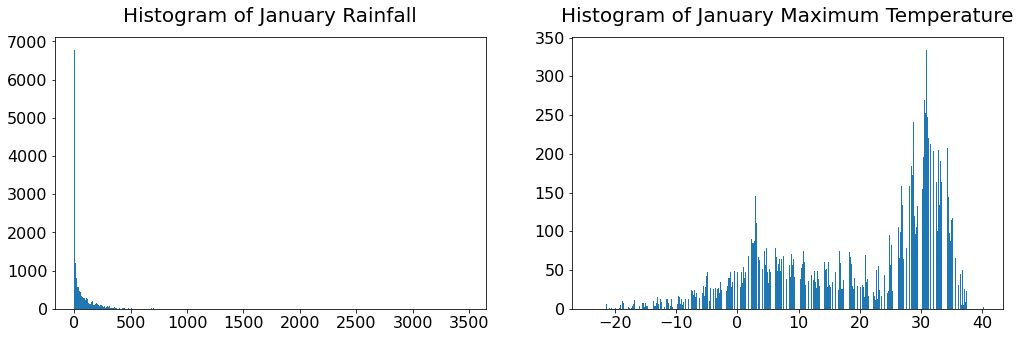

In [6]:
fig, ax = plt.subplots(1,2, figsize=(17,5))
ax[0].hist(raw_x[:,1], bins=1000)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_title('Histogram of January Rainfall', fontsize=20, pad=15)
ax[1].hist(raw_x[:,3], bins=1000)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_title('Histogram of January Maximum Temperature', fontsize=20, pad=15)
plt.savefig('rain_temp_hists.png', bbox_inches='tight')
plt.show()

### Normalise and standardise functions...

In [7]:
def normalise_data(x_unnormalised):
    x_min = np.amin(x_unnormalised, axis=0)
    x_range = np.amax(x_unnormalised, axis=0) - x_min
    return (x_unnormalised - x_min) / x_range

def standardise_data(x_unstandardised):
    mean = np.mean(x_unstandardised, axis=0)
    std = x_unstandardised.std(axis=0)
    a = std
    b = mean
    x_standardised = (x_unstandardised / a) - (b / a)
    return x_standardised, a, b

# Standardisation checking function...
def stand_check(x_standardised, x_unstandardised, a, b):
    x_undo_stand = (a*x_standardised) + b
    return np.all(np.isclose(x_undo_stand, x_unstandardised))

### Standardisng, removing outliers above 10 std's from mean and then normalising...

In [8]:
# Standardising the dataset...
x_stand, m, std = standardise_data(raw_x)
# Testing standardisation...
print('Standardisation successful:', stand_check(x_stand, raw_x, m, std))

# Removing outliers 10 std's above mean...
print('x in:', x_stand.shape)
print('y in:', raw_y.shape)
def remove_outliers(x_matrix, y_matrix):
    find_outliers = np.all(np.abs(x_matrix) < 10, axis=1)
    return np.array(x_matrix[find_outliers]), np.array(y_matrix[find_outliers])

x_stand, raw_y = remove_outliers(x_stand, raw_y)

print('x out:', x_stand.shape)
print('y out:', raw_y.shape)

# Normalising data...
x_norm = normalise_data(x_stand)
print('Normalised')

Standardisation successful: True
x in: (31728, 37)
y in: (31728,)
x out: (31625, 37)
y out: (31625,)
Normalised


### Skew after standardising...

In [9]:
print('\nList of features and their skew:')
print('='*30,'', '='*6)
print(' '*30, '  Skew')
print('='*30,'','='*6)
skews = np.mean(x_stand**3, axis=0)
for col, feature in enumerate(header[:-1]):
    print('-> {}:'.format(feature), ' '*(26-len(feature)), \
         round(skews[col], 2))


List of features and their skew:
==============================  ======
                                 Skew
==============================  ======
-> year:                        -0.0
-> jan rain:                    1.77
-> jan mean min temperature:    -0.75
-> jan mean max temperature:    -0.67
-> feb rain:                    2.63
-> feb mean min temperature:    -0.72
-> feb mean max temperature:    -0.63
-> mar rain:                    2.1
-> mar mean min temperature:    -0.61
-> mar mean max temperature:    -0.58
-> apr rain:                    2.09
-> apr mean min temperature:    -0.37
-> apr mean max temperature:    -0.61
-> may rain:                    1.66
-> may mean min temperature:    -0.41
-> may mean max temperature:    -1.04
-> jun rain:                    2.21
-> jun mean min temperature:    -0.92
-> jun mean max temperature:    -1.51
-> jul rain:                    1.87
-> jul mean min temperature:    -1.15
-> jul mean max temperature:    -1.71
-> aug rain:           

### Boxplots of normalised, standardised and raw features (top to bottom)

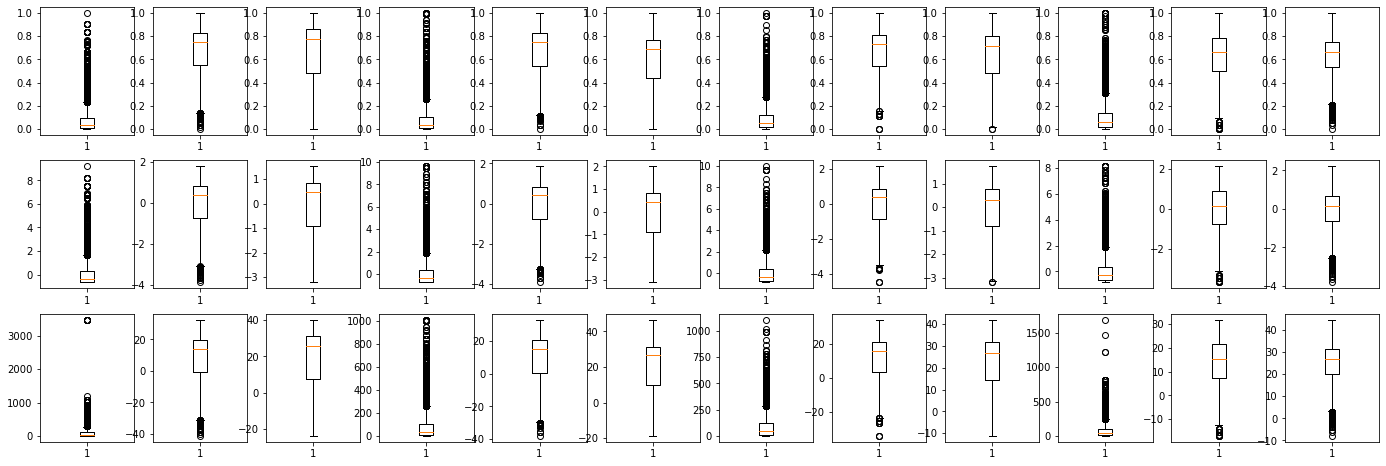

In [10]:
fig, axes = plt.subplots(3,12, figsize=(24,8))
for feature in range(1,13):
    axes[0,feature-1].boxplot(x_norm[:,feature])
    axes[1,feature-1].boxplot(x_stand[:,feature])
    axes[2,feature-1].boxplot(raw_x[:,feature])
plt.show()

### Principle component analysis...

In [11]:
def PCA(x):
    covar_x = np.cov(x.T)
    # Find eigenvalues and eigenvectors...
    evals, evecs = np.linalg.eigh(covar_x)

    energy = np.cumsum(evals)
    count = 0
    while energy[count+1] < 0.03*energy[-1]:
        count += 1
    # Create rotation matrix...
    project = evecs[:, count:][:, ::-1].T
    # Apply rotation matrix to data...
    proj_x = project.dot(x.T).T
    print('New shape of X is', proj_x.shape)
    print('Kept {}% of total energy'.format(np.round(np.sum(evals[count:])*100/np.sum(evals), 3)))
    return proj_x

x = PCA(x_stand)

New shape of X is (31625, 16)
Kept 97.913% of total energy


### Splitting into Train, Test and Validation sets...
Here I will randomly shuffle the data and split this initailly into train and test sets with an 70:30 ratio, then split the test set into test and validation with a 50:50 ratio.

In [12]:
total_obs = x.shape[0]

# Randomly shuffling observations...
np.random.seed(4)
shuffle = np.random.permutation(total_obs)
x = x[shuffle]
y = raw_y[shuffle]

# Splitting off training set...
split = int(total_obs * 0.7)

train_x = x[:split]
train_y = y[:split]

test_val_x = x[split:]
test_val_y = y[split:]

# Splitting the rest into test and validation sets...
test_split = int(test_val_x.shape[0] * 0.5)

test_x = test_val_x[:test_split]
test_y = test_val_y[:test_split]

val_x = test_val_x[test_split:]
val_y = test_val_y[test_split:]

print('Training set size:', train_x.shape[0])
print('Test set size:', test_x.shape[0])
print('Validation set size:', val_x.shape[0])

Training set size: 22137
Test set size: 4744
Validation set size: 4744


## 2D scatterplot of data after PCA...

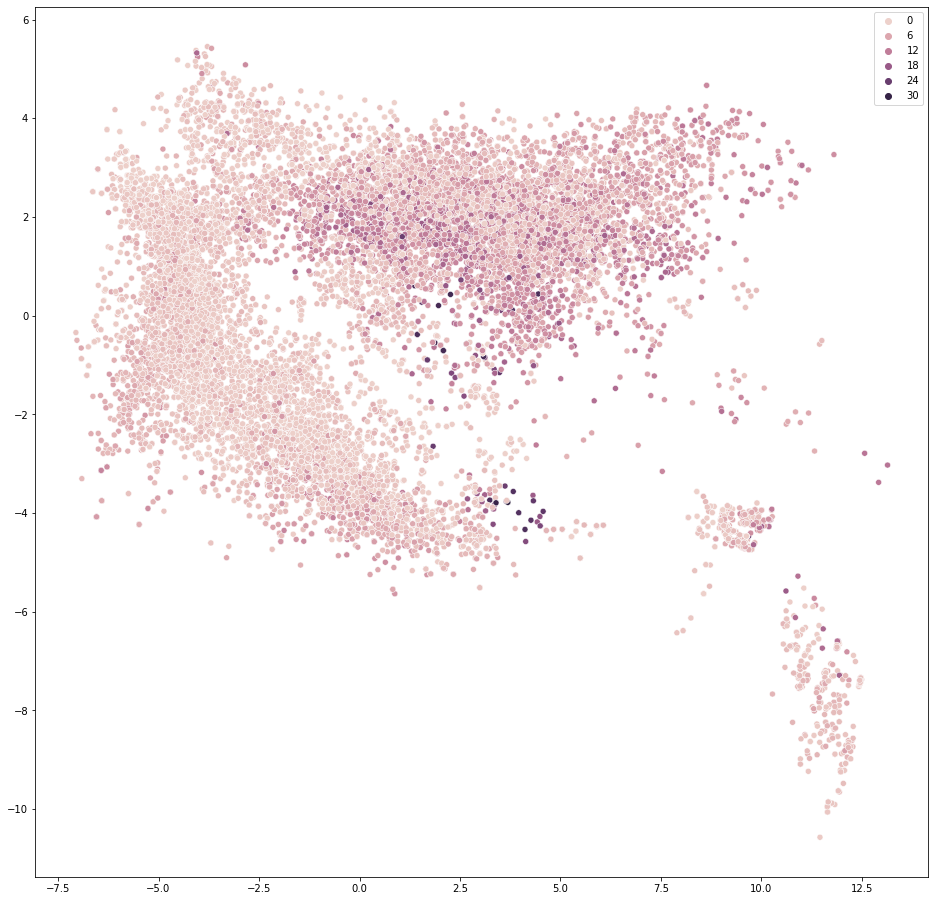

In [13]:
plt.figure(figsize=(16,16))
sns.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=train_y)
plt.savefig('2d_PCA.png', bbox_inches='tight')
plt.show()

### Visualising year vs. crop yield...
There appears to be a correlation between year and crop yield, hence I will keep the year information in the dataset.

<AxesSubplot:>

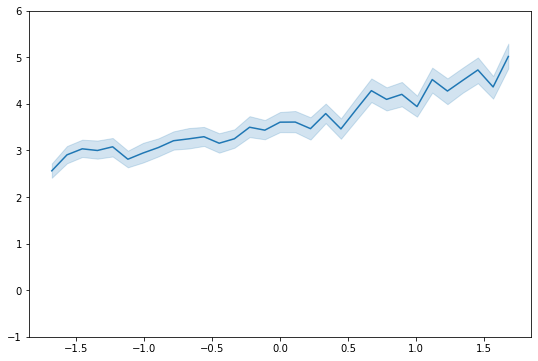

In [14]:
plt.figure(figsize=(9,6))
plt.ylim(-1, 6)
sns.lineplot(x=x_stand[:,0], y=raw_y)

## Toy Problem...

In [15]:
# Generating features...
alpha = np.linspace(-2, 2, 10000)           # np.linspace(-4, 4, 500)
                                                      #beta = np.linspace(-10, 10, 500)**2
all_toy_y = 2*(alpha**2) + 0.5   # 2*np.sin(alpha) + 2                       # all_toy_y = 2*alpha - 1.5*beta + 0.25

# Standardising features...
all_toy_x = standardise_data(alpha)[0]
'''
# Normalising...
a_min = alpha.min()
a_range = alpha.max() - a_min
all_toy_x = (alpha - a_min) / a_range
'''
# Randomly shuffling observations...
np.random.seed(2)
shuffle = np.random.permutation(10000)
all_toy_x = all_toy_x[shuffle]
all_toy_y = all_toy_y[shuffle]

# Splitting into train and test sets...
# Train...
toy_x = all_toy_x[:8500]
toy_y = all_toy_y[:8500]
# Test...
toy_tst_x = all_toy_x[8500:]
toy_tst_y = all_toy_y[8500:]

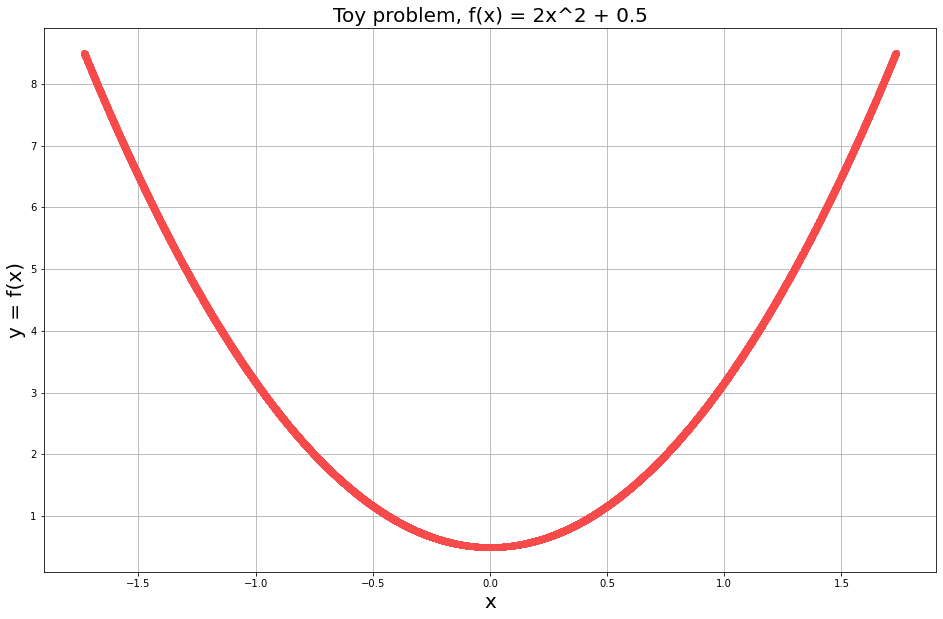

In [16]:
# Plotting a graph of toy problem...
plt.figure(figsize=(16,10))
plt.ylabel('y = f(x)', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.title('Toy problem, f(x) = 2x^2 + 0.5', fontsize=20)
plt.grid()
plt.plot(toy_x, toy_y, '#f74a4a', marker='o', linestyle='')
plt.savefig('toy_func.png', bbox_inches='tight')
plt.show()

## Linear Regression...

### Linear Regression on toy problem...

In [17]:
tf.reset_default_graph()

# Constants to hold the training data...
t_x_train = tf.constant(toy_x.T, name='x_train')
t_y_train = tf.constant(toy_y, name='y_train')

# Initial values for optimisation...
dims = np.ndim(toy_x)
w_initial_guess = np.zeros(dims).reshape(1,dims)
c_initial_guess = 0

# Variables to hold w's and c...
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

def calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c, x_dim):
    if x_dim > 1:
        errors = (t_y_train - tf.matmul(t_w, t_x_train) - t_c)**2
    else:
        errors = ((t_y_train - t_w*t_x_train) - t_c)**2
    l_s_e = tf.reduce_sum(errors)
    t_least_squares_error = (l_s_e)
    return t_least_squares_error

# Print intial least squares error...
tensorflow_result = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c, dims)
print('Least squares error =', tensorflow_result.numpy())

# Define optimiser and its learning rate...
optimiser = tf.train.GradientDescentOptimizer(learning_rate=3e-5) # 1e-4

# Number of iterations to perform...
num_iterations = 5000   # 150
old_loss = tensorflow_result*9999

# Run iterations of gradient descent...
for iteration in range(num_iterations):
    with tf.GradientTape() as tape:
        # Minimising the least squares error...
        loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c, dims)
    
    # Calculate gradients...
    tf_grad_w, tf_grad_c = tape.gradient(loss, ((t_w), t_c))
    
    # Create a gradient descent optimiser...
    optimiser.apply_gradients(zip((tf_grad_w,tf_grad_c),(t_w,t_c)))
    
    # Printing progress every ten iterations...
    if (iteration+1) % 10 == 0:
        print('iter %4d, E(w,c) = %0.18f' % (iteration + 1, loss))
    
    # Check whether sufficiently converged...
    if (old_loss - loss) < 1e-8:
        print('Sufficiently converged.')
        break
    old_loss = loss

# Get the final results of the optimisation...
w_tf_opt = t_w.numpy()
c_tf_opt = t_c.numpy()

print('\nAfter tensorflow optimisation:')
print('Tensorflow w = ', np.round(w_tf_opt,4))
print('Tensorflow c = ', round(c_tf_opt,4))

Least squares error = 135653.87444788602
iter   10, E(w,c) = 48717.733365237378166057
iter   20, E(w,c) = 48717.502867326744308230
Sufficiently converged.

After tensorflow optimisation:
Tensorflow w =  [[0.0255]]
Tensorflow c =  3.198


### Predict toy problem test values...
Accuracy is measured via the RMSE.

In [25]:
def performance(test_predicts, test_y):
    MAE = np.abs(test_y - test_predicts).mean()
    RMSE = np.sqrt(((test_y - test_predicts)**2).mean())
    R2 = 1 - (np.sum((test_y - test_predicts)**2) / np.sum((test_y - np.mean(test_y))**2))
    print('MAE =', MAE)
    print('RMSE =', RMSE)
    print('R-Squared =', R2)

In [19]:
# Predicting test y-values of toy problem...
pred_w = w_tf_opt
pred_c = c_tf_opt

if np.ndim(toy_x) > 1:
    pred_test_y = np.matmul(pred_w, toy_tst_x.T) + pred_c
else:
    pred_w = pred_w.reshape(1)
    toy_tst_x = toy_tst_x.reshape(toy_tst_x.size)
    pred_test_y = (pred_w*toy_tst_x) + pred_c

# Calculating RMSE...
rmse = np.sqrt(((toy_tst_y - pred_test_y)**2).mean())
mae = np.abs(toy_tst_y - pred_test_y).mean()
R2 = 1 - (np.sum((toy_tst_y - pred_test_y)**2) / np.sum((toy_tst_y - np.mean(toy_tst_y))**2))
print('RMSE =', rmse)
print('MAE =', mae)
print('R-Squared =', R2)

RMSE = 2.339534262411784
MAE = 2.027755300414288
R-Squared = -0.009258784471662285


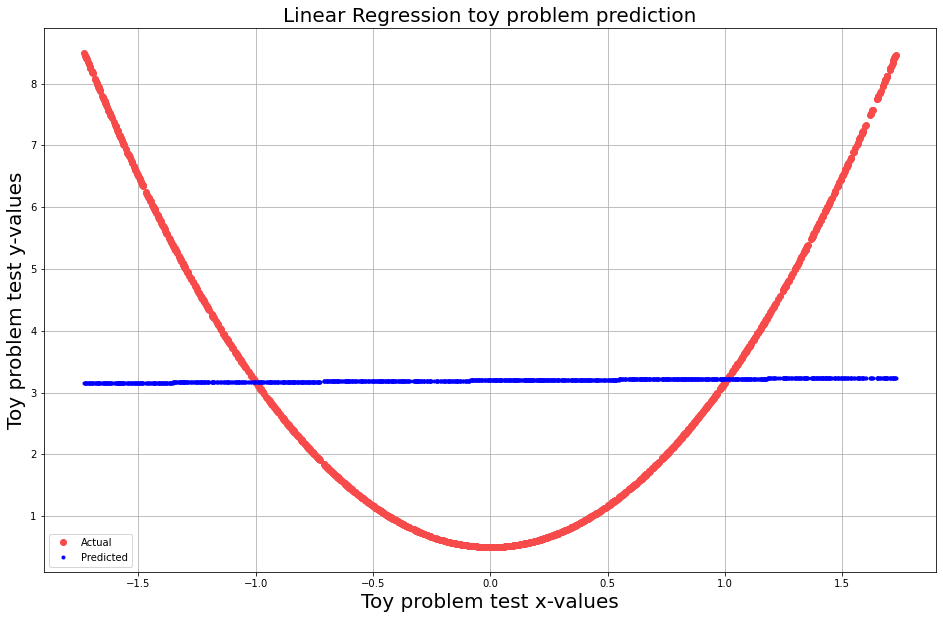

In [20]:
# Plotting graph of predicted vs true y-values...
plt.figure(figsize=(16,10))
plt.ylabel('Toy problem test y-values', fontsize=20)
plt.xlabel('Toy problem test x-values', fontsize=20)
plt.title('Linear Regression toy problem prediction', fontsize=20)
plt.grid()
plt.plot(toy_tst_x, toy_tst_y, '#f74a4a', marker='o', linestyle='', label='Actual')
plt.plot(toy_tst_x, pred_test_y, 'b.', label='Predicted')
plt.legend()
plt.savefig('LR_toy.png', bbox_inches='tight')
plt.show()

### Linear Regression on actual data...

In [21]:
tf.reset_default_graph()
t1 = time.time()
# Constants to hold the training data...
t_x_train = tf.constant(train_x.T, name='x_train')
t_y_train = tf.constant(train_y, name='y_train')

# Initial values for optimisation...
w_initial_guess = np.ones((1,train_x.shape[1]))*0.5
c_initial_guess = 0.5

# Variables to hold w's and c...
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

def calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c):
    errors = (t_y_train - tf.matmul(t_w, t_x_train) - t_c)**2
    l_s_e = tf.reduce_sum(errors)
    t_least_squares_error = (l_s_e)
    return t_least_squares_error

# Print intial least squares error...
tensorflow_result = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
print('Initial least squares error =', tensorflow_result.numpy())

# Define optimiser and its learning rate...
optimiser = tf.train.GradientDescentOptimizer(learning_rate = 2e-6)

# Number of iterations to perform...
num_iterations = 10000
old_loss = tensorflow_result*9999

# Run iterations of gradient descent...
for iteration in range(num_iterations):
    with tf.GradientTape() as tape:
        # Calculate least squares error...
        loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)

    # Calculate gradients...
    tf_grad_w, tf_grad_c = tape.gradient(loss, (t_w, t_c))

    # Create a gradient descent optimiser...
    optimiser.apply_gradients(zip((tf_grad_w,tf_grad_c),(t_w,t_c)))

    # Printing progress every 100 iterations...
    if (iteration+1) % 100 == 0:
        print('iter %4d, E(w,c) = %0.5f' % (iteration + 1, loss))

    # Check whether sufficiently converged...
    if (old_loss - loss) < 1e-9:
        print('Sufficiently converged.')
        break
    old_loss = loss

# Get the final results of the optimisation..
w_tf_opt = t_w.numpy()
c_tf_opt = t_c.numpy()
t2 = time.time()
print('\nAfter tensorflow optimisation:')
print('Tensorflow w = ', w_tf_opt)
print('Tensorflow c = ', c_tf_opt)
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nLinear regressor trained in {} mins and {} seconds!'.format(mins, secs))

Initial least squares error = 578895.1981547084
iter  100, E(w,c) = 207155.16134
iter  200, E(w,c) = 207053.43195
iter  300, E(w,c) = 207051.64697
iter  400, E(w,c) = 207051.60595
iter  500, E(w,c) = 207051.60494
iter  600, E(w,c) = 207051.60491
Sufficiently converged.

After tensorflow optimisation:
Tensorflow w =  [[ 0.32011596  0.25917427 -0.63507703  0.32805984 -0.63946317  0.19178214
  -0.25808739  0.06642708 -0.07245218  0.454655   -0.12202135  0.14400213
  -0.08196129  0.0571387  -0.06276706 -0.08274571]]
Tensorflow c =  3.65093737673611

Linear regressor trained in 0 mins and 1.8728702068328857 seconds!


### Predict test yields...

In [22]:
# Test predictions...
t1 = time.time()
pred_w = w_tf_opt
pred_c = c_tf_opt
pred_test_y = np.matmul(pred_w, test_x.T) + pred_c
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('Linear regressor evalution took in {} mins and {} seconds\n'.format(mins, secs))

# Printing performance...
performance(pred_test_y, test_y)

Linear regressor evalution took in 0 mins and 0.00889730453491211 seconds

MAE = 2.12094031561918
RMSE = 3.0033512268780815
R-Squared = 0.3074836786472791


In [23]:
learn_rates = [2.5e-6, 1e-6, 7.5e-7, 5e-7, 2.5e-7,1e-7,7.5e-8]
iterations = np.arange(5000)
losses = np.zeros((5000, 7))

for n, learn_rate in enumerate(learn_rates): 
    print(learn_rate)
    tf.reset_default_graph()
    t1 = time.time()
    # Constants to hold the training data...
    t_x_train = tf.constant(train_x.T, name='x_train')
    t_y_train = tf.constant(train_y, name='y_train')

    # Initial values for optimisation...
    w_initial_guess = np.ones((1,train_x.shape[1]))*0.5
    c_initial_guess = 0.5

    # Variables to hold w's and c...
    t_w = tf.Variable(w_initial_guess, 
                      dtype=tf.float64, 
                      name='w')
    t_c = tf.Variable(c_initial_guess, 
                      dtype=tf.float64, 
                      name='c')

    def calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c):
        errors = (t_y_train - tf.matmul(t_w, t_x_train) - t_c)**2
        l_s_e = tf.reduce_sum(errors)
        t_least_squares_error = (l_s_e)
        return t_least_squares_error

    # Print intial least squares error...
    tensorflow_result = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
    print('Initial least squares error =', tensorflow_result.numpy())

    # Define optimiser and its learning rate...
    optimiser = tf.train.GradientDescentOptimizer(learning_rate = learn_rate)

    # Number of iterations to perform...
    num_iterations = 10000
    old_loss = tensorflow_result*9999

    # Run iterations of gradient descent...
    for iteration in iterations:
        with tf.GradientTape() as tape:
            # Calculate least squares error...
            loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
            losses[iteration,n] = loss
        
        # Calculate gradients...
        tf_grad_w, tf_grad_c = tape.gradient(loss, (t_w, t_c))

        # Create a gradient descent optimiser...
        optimiser.apply_gradients(zip((tf_grad_w,tf_grad_c),(t_w,t_c)))

        # Printing progress every 100 iterations...
        if (iteration+1) % 100 == 0:
            print('iter %4d, E(w,c) = %0.5f' % (iteration + 1, loss))

2.5e-06
Initial least squares error = 578895.1981547084
iter  100, E(w,c) = 207087.40482
iter  200, E(w,c) = 207051.87436
iter  300, E(w,c) = 207051.60747
iter  400, E(w,c) = 207051.60494
iter  500, E(w,c) = 207051.60491
iter  600, E(w,c) = 207051.60491
iter  700, E(w,c) = 207051.60491
iter  800, E(w,c) = 207051.60491
iter  900, E(w,c) = 207051.60491
iter 1000, E(w,c) = 207051.60491
iter 1100, E(w,c) = 207051.60491
iter 1200, E(w,c) = 207051.60491
iter 1300, E(w,c) = 207051.60491
iter 1400, E(w,c) = 207051.60491
iter 1500, E(w,c) = 207051.60491
iter 1600, E(w,c) = 207051.60491
iter 1700, E(w,c) = 207051.60491
iter 1800, E(w,c) = 207051.60491
iter 1900, E(w,c) = 207051.60491
iter 2000, E(w,c) = 207051.60491
iter 2100, E(w,c) = 207051.60491
iter 2200, E(w,c) = 207051.60491
iter 2300, E(w,c) = 207051.60491
iter 2400, E(w,c) = 207051.60491
iter 2500, E(w,c) = 207051.60491
iter 2600, E(w,c) = 207051.60491
iter 2700, E(w,c) = 207051.60491
iter 2800, E(w,c) = 207051.60491
iter 2900, E(w,c) = 

iter 4100, E(w,c) = 207051.60493
iter 4200, E(w,c) = 207051.60492
iter 4300, E(w,c) = 207051.60492
iter 4400, E(w,c) = 207051.60492
iter 4500, E(w,c) = 207051.60491
iter 4600, E(w,c) = 207051.60491
iter 4700, E(w,c) = 207051.60491
iter 4800, E(w,c) = 207051.60491
iter 4900, E(w,c) = 207051.60491
iter 5000, E(w,c) = 207051.60491
1e-07
Initial least squares error = 578895.1981547084
iter  100, E(w,c) = 334622.46749
iter  200, E(w,c) = 262340.99156
iter  300, E(w,c) = 233020.17954
iter  400, E(w,c) = 220166.57663
iter  500, E(w,c) = 214256.19540
iter  600, E(w,c) = 211379.27563
iter  700, E(w,c) = 209872.75985
iter  800, E(w,c) = 209014.33028
iter  900, E(w,c) = 208482.06370
iter 1000, E(w,c) = 208127.03021
iter 1100, E(w,c) = 207876.62523
iter 1200, E(w,c) = 207692.97381
iter 1300, E(w,c) = 207554.71466
iter 1400, E(w,c) = 207448.81404
iter 1500, E(w,c) = 207366.74777
iter 1600, E(w,c) = 207302.62805
iter 1700, E(w,c) = 207252.22399
iter 1800, E(w,c) = 207212.41105
iter 1900, E(w,c) = 20

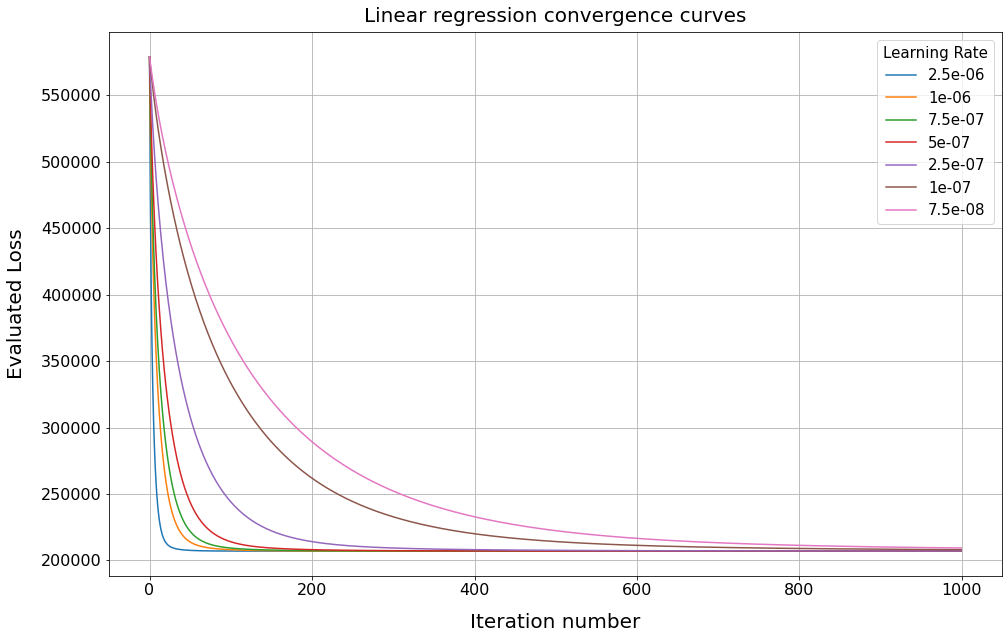

In [24]:
fig = plt.figure(figsize=(16,10))
plt.ylabel('Evaluated Loss', fontsize=20, labelpad=15)
plt.xlabel('Iteration number', fontsize=20, labelpad=15)
plt.title('Linear regression convergence curves', fontsize=20, pad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.plot(iterations[:1000], losses[:,0][:1000], label=str(learn_rates[0]))
plt.plot(iterations[:1000], losses[:,1][:1000], label=str(learn_rates[1]))
plt.plot(iterations[:1000], losses[:,2][:1000], label=str(learn_rates[2]))
plt.plot(iterations[:1000], losses[:,3][:1000], label=str(learn_rates[3]))
plt.plot(iterations[:1000], losses[:,4][:1000], label=str(learn_rates[4]))
plt.plot(iterations[:1000], losses[:,5][:1000], label=str(learn_rates[5]))
plt.plot(iterations[:1000], losses[:,6][:1000], label=str(learn_rates[6]))
plt.legend(title='Learning Rate', fontsize=15, title_fontsize=15)
plt.savefig('LR_lr_tuned.png', bbox_inches='tight')
plt.show()

## Regression Forest...
### Creating decision tree...

In [25]:
def calculate_var(y):
    # Make sure we don't divide by zero...
    n = y.size
    if n == 0:
        return np.inf
    else:
        # Return the variance...
        return y.var()

In [26]:
def find_split(x, y, ftr_sampling, min_split_size, n_samples, multi_dim=True):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the minimum variance sum."""
    
    # Best thus far, initialised to a dud that will be replaced immediately...
    best = {'var' : np.inf}
    n = y.size
    
    if multi_dim == True:
        # Selecting random feature sub-space...
        if ftr_sampling == True:
            num_features = int(np.sqrt(x.shape[1]))
            rand_feature_inds = np.random.choice(x.shape[1], size=num_features, replace=False)
        else:
            rand_feature_inds = range(x.shape[1])
    
        # Loop every possible split of every dimension...
        for i in rand_feature_inds:
            split_index = 0
            for split in np.unique(x[:,i]):
                # Divide the data...
                left_indices = np.where(x[:, i] <= split)[0]
                right_indices = np.where(x[:, i] > split)[0]

                # Set minimum split size limit...
                if min_split_size < 1:
                    if (left_indices.size < min_split_size*n_samples) or (right_indices.size < min_split_size*n_samples):
                        continue
                else:
                    if (left_indices.size < min_split_size) or (right_indices.size < min_split_size):
                        continue

                # Calculate variances...
                left_var = calculate_var(y[left_indices])
                right_var = calculate_var(y[right_indices])

                # Calculate variance sum...
                var_sum = (left_indices.size/n)*left_var + (right_indices.size/n)*right_var

                # Find minimum variance...
                if var_sum < best['var']:
                    # Assign new minimum variance...
                    best = {'feature' : i,
                            'split' : split,
                            'var' : var_sum, 
                            'left_indices' : left_indices.tolist(),
                            'right_indices' : right_indices.tolist()}
                split_index += 1
    
    else:   
        # Loop every possible split...
        split_index = 0
        for split in np.unique(x):
            # Divide the data...
            left_indices = np.where(x <= split)[0]
            right_indices = np.where(x > split)[0]

            # Set minimum split size limit...
            if min_split_size < 1:
                if (left_indices.size < min_split_size*n_samples) or (right_indices.size < min_split_size*n_samples):
                    continue
            else:
                if (left_indices.size < min_split_size) or (right_indices.size < min_split_size):
                    continue

            # Calculate variances...
            left_var = calculate_var(y[left_indices])
            right_var = calculate_var(y[right_indices])

            # Calculate variance sum...
            var_sum = (left_indices.size/n)*left_var + (right_indices.size/n)*right_var

            # Find minimum variance...
            if var_sum < best['var']:
                # Assign new minimum variance...
                best = {'split' : split,
                        'var' : var_sum, 
                        'left_indices' : left_indices.tolist(),
                        'right_indices' : right_indices.tolist()}
            split_index += 1
    
    return best

In [27]:
def build_tree(x, y, n_samples, max_depth = np.inf, ftr_sampling=False, min_split_size=0, min_leaf_size=5, multi_dim=True):
    
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    if (max_depth==0) or (y.size <= min_leaf_size):  # or (np.isclose(y, y[0], rtol=1e-2).all()):
        # Generate a leaf node with the predicted mean value...
        return {'leaf' : True, 'mean' : y.mean()}
    
    else:
        # Finding the optimal split indices...
        move = find_split(x, y, ftr_sampling, min_split_size, n_samples, multi_dim)
        
        # X data is either 1D or multi-dimensional...
        if multi_dim == True:
            # Ensuring no leaves are empty...
            if move['var'] == np.inf or move['left_indices'] == [] or move['right_indices'] == []:
                return {'leaf' : True, 'mean' : y.mean()}

            # Repeating the processing for left & right daughter nodes...
            left = build_tree(x[move['left_indices'],:], y[move['left_indices']], n_samples, max_depth - 1, \
                              ftr_sampling, min_split_size, min_leaf_size, multi_dim)
            right = build_tree(x[move['right_indices'],:], y[move['right_indices']], n_samples, max_depth - 1, \
                               ftr_sampling, min_split_size, min_leaf_size, multi_dim)
            return {'leaf' : False,
                    'feature' : move['feature'],
                    'split' : move['split'],
                    'var' : move['var'],
                    'left' : left,
                    'right' : right}
        else:
            # Ensuring no leaves are empty...
            if move['var'] == np.inf or move['left_indices'] == [] or move['right_indices'] == []:
                return {'leaf' : True, 'mean' : y.mean()}

            # Repeating the processing for left & right daughter nodes...
            left = build_tree(x[move['left_indices']], y[move['left_indices']], n_samples, max_depth - 1, \
                              ftr_sampling, min_split_size, min_leaf_size, multi_dim)
            right = build_tree(x[move['right_indices']], y[move['right_indices']], n_samples, max_depth - 1, \
                               ftr_sampling, min_split_size, min_leaf_size, multi_dim)
            return {'leaf' : False,
                    'split' : move['split'],
                    'var' : move['var'],
                    'left' : left,
                    'right' : right}

### Creating regression forest...

In [28]:
def forest_train(x, y, num_samples=10, ftr_sampling=False, max_depth=2, min_split_size=0, min_leaf_size=5, print_progress = True, multi_dim=True):
    '''
    - To activate feature sub-sampling select ftr_sampling=True
    - To enforce a minimum split size, input minimum percentage as min_split_size parameter 
    '''
    forest = []
    n = 0
    
    # Checking whether X is multi-dimensional...
    if np.ndim(x) == 1:
        multi_dim = False
    
    for _ in range(num_samples):
        # New tree...
        # Generating random sample indices (bootstrap)...
        rand_inds = np.random.choice(y.size, size=y.size)
        
        # If multi-dimensional...
        if multi_dim == True:
            # Generating random sub-samples...
            train_x_sample = x[rand_inds, :]
            train_y_sample = y[rand_inds]
        
        # If only 1 feature...
        else:
            # Generating random sub-samples...
            train_x_sample = x[rand_inds]
            train_y_sample = y[rand_inds]
        
        # Building tree...
        tree = build_tree(train_x_sample, train_y_sample, n_samples=y.size, max_depth=max_depth, \
                          ftr_sampling=ftr_sampling, min_split_size=min_split_size, \
                          min_leaf_size=min_leaf_size, multi_dim=multi_dim)
        
        # Adding tree to the forest...
        forest.append(tree)
        n+=1
        if print_progress == True:
            print('Tree {} trained'.format(n))
    
    return forest

In [29]:
def forest_predict(forest, samples):
    predictions = []
    
    if np.ndim(samples) == 1:
        # Creating predictions using each tree in forest...
        for tree in forest:
            prediction = np.empty(samples.shape[0])
            prediction.fill(-1)
            indices = np.arange(samples.shape[0])

            def tranverse(node, indices):
                nonlocal samples
                nonlocal prediction

                if node['leaf']:
                    prediction[indices] = node['mean']

                else:
                    going_left = samples[indices] <= node['split']
                    left_indices = indices[going_left]
                    right_indices = indices[np.logical_not(going_left)]

                    if left_indices.shape[0] > 0:
                        tranverse(node['left'], left_indices)

                    if right_indices.shape[0] > 0:
                        tranverse(node['right'], right_indices)
            
            tranverse(tree, indices)
            # Adding prediction to list...
            predictions.append(prediction)
        
    else:
        # Creating predictions using each tree in forest...
        for tree in forest:
            prediction = np.empty(samples.shape[0])
            prediction.fill(-1)
            indices = np.arange(samples.shape[0])

            def tranverse(node, indices):
                nonlocal samples
                nonlocal prediction

                if node['leaf']:
                    prediction[indices] = node['mean']

                else:
                    going_left = samples[indices, node['feature']] <= node['split']
                    left_indices = indices[going_left]
                    right_indices = indices[np.logical_not(going_left)]

                    if left_indices.shape[0] > 0:
                        tranverse(node['left'], left_indices)

                    if right_indices.shape[0] > 0:
                        tranverse(node['right'], right_indices)
            
            tranverse(tree, indices)
            # Adding prediction to list...
            predictions.append(prediction)
        
    return predictions

### Regression Forest with Toy Problem

In [ ]:
# Measure training time...
t1 = time.time()

# Training random forest...
forest = forest_train(toy_x, toy_y, num_samples=30, max_depth=np.inf, \
                      ftr_sampling=True, min_split_size=1, min_leaf_size=1)
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nForest trained in {} mins and {} seconds!'.format(mins, secs))

# Predicting test y-values...
train_predictions = forest_predict(forest, toy_x)
test_predictions = forest_predict(forest, toy_tst_x)

# Finding average prediction...
train_prediction = np.mean(train_predictions, axis=0)
test_prediction = np.mean(test_predictions, axis=0)

# Calculating prediction accuracy...
# Train...
train_MAE = np.abs((toy_y - train_prediction)).mean()
train_RMSE = np.sqrt(((toy_y - train_prediction)**2).mean())
# Test...
test_MAE = np.abs((toy_tst_y - test_prediction)).mean()
test_RMSE = np.sqrt(((toy_tst_y - test_prediction)**2).mean())
print('\nTrain MAE =', train_MAE)
print('Train RMSE =', train_RMSE)
print('\nTest MAE =', test_MAE)
print('Test RMSE =', test_RMSE)

Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
Tree 6 trained
Tree 7 trained
Tree 8 trained
Tree 9 trained
Tree 10 trained
Tree 11 trained
Tree 12 trained
Tree 13 trained
Tree 14 trained
Tree 15 trained
Tree 16 trained
Tree 17 trained
Tree 18 trained
Tree 19 trained
Tree 20 trained
Tree 21 trained
Tree 22 trained
Tree 23 trained
Tree 24 trained
Tree 25 trained


In [ ]:
# Plotting graph of predicted vs true y-values...
plt.figure(figsize=(16,10))
#plt.ylabel('Toy problem test y-values', fontsize=20)
plt.xlabel('Toy problem test x-values', fontsize=20)
plt.title('Random forest toy problem incorrect predictions', fontsize=20)
plt.grid()
plt.plot(toy_x, toy_y, '#f74a4a', marker='o', linestyle='', label='Actual')
plt.plot(toy_x, train_prediction, 'b.', label='Predicted')
plt.legend()
plt.savefig('FR_toy_wrong.png', bbox_inches='tight')
plt.show()

### Regression Forest to predict crop yield...

In [ ]:
t1 = time.time()
# Training random forest...
forest = forest_train(train_x, train_y, num_samples=1, max_depth=8, \
                      ftr_sampling=True, min_split_size=6e-4, min_leaf_size=7)
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nForest trained in {} mins and {} seconds!'.format(mins, secs))

# Predicting test y-values...
train_predictions = forest_predict(forest, train_x)
t1 = time.time()
test_predictions = forest_predict(forest, test_x)
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nForest predictions took in {} mins and {} seconds!'.format(mins, secs))

# Finding average prediction...
train_prediction = np.mean(train_predictions, axis=0)
test_prediction = np.mean(test_predictions, axis=0)

# Printing performance...
print('Training set performance:\n')
performance(train_prediction, train_y)
print('Test set performance:\n')
performance(test_prediction, test_y)

In [ ]:
AE = np.abs(test_prediction - test_y)
plt.figure(figsize=(14,10))
plt.hist(AE, bins=1000)
plt.title('Histogram of Random Forest absolute errors')
plt.show()

### Hyperparameter tuning...
#### Grid Search Method:

In [ ]:
def forest_grid_tuner(train_x, train_y, val_x, val_y, num_samples):
    best = {'RMSE': np.inf}
    for depth in range(4,10):
        print('New depth =', depth)
        for min_split in [0.01,0.1,0.2]:
            print('New min_split =', min_split)
            for min_leaf in [5,15,30]:
                # Training random forest with specific hyperparameters using validation set...
                forest = forest_train(train_x, train_y, num_samples=num_samples, max_depth=depth, \
                                      ftr_sampling=True, min_split_size=min_split, min_leaf_size=min_leaf, print_progress = False)
                # Testing hyperparameters using validation set...
                # Predicting validation y-values...
                val_predictions = forest_predict(forest, val_x)

                # Finding average prediction...
                val_prediction = np.mean(val_predictions, axis=0)

                # Calculating prediction accuracy...
                #val_MAE = np.abs((val_y - val_prediction)).mean()
                val_RMSE = np.sqrt(((val_y - val_prediction)**2).mean())
                 # Find best hyperparameters...
                if val_RMSE < best['RMSE']:
                    print('New best RMSE:', val_RMSE)
                    best = {'RMSE' : val_RMSE,
                            'depth' : depth,
                            'min_split' : min_split,
                            'min_leaf' : min_leaf}
    return best

#### Random Search Method:

In [ ]:
def d_forest_rand_tuner(train_x, train_y, val_x, val_y, num_samples, num_searches=10):
    best = {'RMSE': np.inf}
    depth_list = np.arange(1, 13)
    #min_split_list = []
    #min_leaf_list = []
    rf_rmse_trn_list = []
    rf_rmse_val_list = []
    
    for rand_search in range(num_searches):
        print('Search number:', rand_search + 1)
        depth = depth_list[rand_search]    # np.random.choice(np.arange(6,9))
        min_split = 6e-4    # np.random.rand()*10**(-np.random.choice([1.0,2.0,3.0,4.0,5.0]))
        min_leaf = 7              # (np.random.rand() * 80)
        print('New params =', depth, min_split, min_leaf)
        #depth_list.append(depth)
        #min_split_list.append(min_split)
        #min_leaf_list.append(min_leaf)
        
        # Training random forest with specific hyperparameters using validation set...
        forest = forest_train(train_x, train_y, num_samples=num_samples, max_depth=depth, \
                              ftr_sampling=True, min_split_size=min_split, min_leaf_size=min_leaf, print_progress = True)
        # Testing hyperparameters using validation set...
        # Predicting validation y-values...
        val_predictions = forest_predict(forest, val_x)

        # Finding average prediction...
        val_prediction = np.mean(val_predictions, axis=0)

        # Calculating prediction accuracy...
        val_RMSE = np.sqrt(((val_y - val_prediction)**2).mean())
        rf_rmse_val_list.append(val_RMSE)
        performance(val_prediction, val_y)
        
        # Noting train performance...
        train_predictions = forest_predict(forest, train_x)
        train_prediction = np.mean(train_predictions, axis=0)
        train_RMSE = np.sqrt(((train_y - train_prediction)**2).mean())
        rf_rmse_trn_list.append(train_RMSE)
        
         # Find best hyperparameters...
        if val_RMSE < best['RMSE']:
            print('New best RMSE:', val_RMSE)
            best = {'RMSE' : val_RMSE,
                    'depth' : depth,
                    'min_split' : min_split,
                    'min_leaf' : min_leaf}
    return best, rf_rmse_trn_list, rf_rmse_val_list, depth_list

In [ ]:
def l_forest_rand_tuner(train_x, train_y, val_x, val_y, num_samples, num_searches=10):
    best = {'RMSE': np.inf}
    min_leaf_list = []
    rf_rmse_trn_list = []
    rf_rmse_val_list = []
    min_leaves = np.linspace(1, 70, num_searches)
    
    for rand_search in range(num_searches):
        print('Search number:', rand_search + 1)
        depth = 8    # np.random.choice(np.arange(6,9))
        min_split = 6e-4
        min_leaf = min_leaves[rand_search]
        print('New params =', depth, min_split, min_leaf)
        
        # Training random forest with specific hyperparameters using validation set...
        forest = forest_train(train_x, train_y, num_samples=num_samples, max_depth=depth, \
                              ftr_sampling=True, min_split_size=min_split, min_leaf_size=min_leaf, print_progress = True)
        # Testing hyperparameters using validation set...
        # Predicting validation y-values...
        val_predictions = forest_predict(forest, val_x)

        # Finding average prediction...
        val_prediction = np.mean(val_predictions, axis=0)

        # Calculating prediction accuracy...
        val_RMSE = np.sqrt(((val_y - val_prediction)**2).mean())
        rf_rmse_val_list.append(val_RMSE)
        performance(val_prediction, val_y)
        
        # Noting train performance...
        train_predictions = forest_predict(forest, train_x)
        train_prediction = np.mean(train_predictions, axis=0)
        train_RMSE = np.sqrt(((train_y - train_prediction)**2).mean())
        rf_rmse_trn_list.append(train_RMSE)
        
         # Find best hyperparameters...
        if val_RMSE < best['RMSE']:
            print('New best RMSE:', val_RMSE)
            best = {'RMSE' : val_RMSE,
                    'depth' : depth,
                    'min_split' : min_split,
                    'min_leaf' : min_leaf}
    return best, rf_rmse_trn_list, rf_rmse_val_list, min_leaves

#### Running hyperparameter general tuning...

In [ ]:
# Tuning random forest...
tuned = d_forest_rand_tuner(train_x, train_y, val_x, val_y, num_samples=5, num_searches=12)

best_hypers = tuned[0]
rf_rmse_trn_list_s = tuned[1]
rf_rmse_val_list_s = tuned[2]
depth_list = tuned[3]

fig = plt.figure(figsize=(16,10))
plt.ylabel('RMSE on validation/training set', fontsize=20, labelpad=15)
plt.xlabel('Maximum tree depth', fontsize=20, labelpad=15)
plt.title('Random forest RMSE vs. maximum tree depth', fontsize=20, pad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.plot(depth_list, rf_rmse_trn_list_s, label='Training')
plt.plot(depth_list, rf_rmse_val_list_s, label='Validation')
plt.legend()
plt.savefig('RF_md_tuned.png', bbox_inches='tight')
plt.show()

Search number: 1
New params = 8 0.0006 1.0
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6375834817712696
RMSE = 2.379719207889881
R-Squared = 0.5832456108056967
New best RMSE: 2.379719207889881
Search number: 2
New params = 8 0.0006 2.4081632653061225
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6611855838532121
RMSE = 2.4293959868474184
R-Squared = 0.5656644575843985
Search number: 3
New params = 8 0.0006 3.816326530612245
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6639252098429707
RMSE = 2.4073969887934554
R-Squared = 0.5734949513985124
Search number: 4
New params = 8 0.0006 5.224489795918368
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6365192492156841
RMSE = 2.3881404485874573
R-Squared = 0.5802908094177908
Search number: 5
New params = 8 0.0006 6.63265306122449
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 tr

Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6924935032035195
RMSE = 2.454048583432941
R-Squared = 0.5568047848067306
Search number: 40
New params = 8 0.0006 55.91836734693877
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6771131157298622
RMSE = 2.4498924943666123
R-Squared = 0.5583046728388725
Search number: 41
New params = 8 0.0006 57.326530612244895
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6618106703581947
RMSE = 2.419500190999504
R-Squared = 0.5691956579668702
Search number: 42
New params = 8 0.0006 58.734693877551024
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6766698869074375
RMSE = 2.455527957313257
R-Squared = 0.5562702810867883
Search number: 43
New params = 8 0.0006 60.142857142857146
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.6788150215551105
RMSE = 2.4418162093918894
R-Squared = 0.

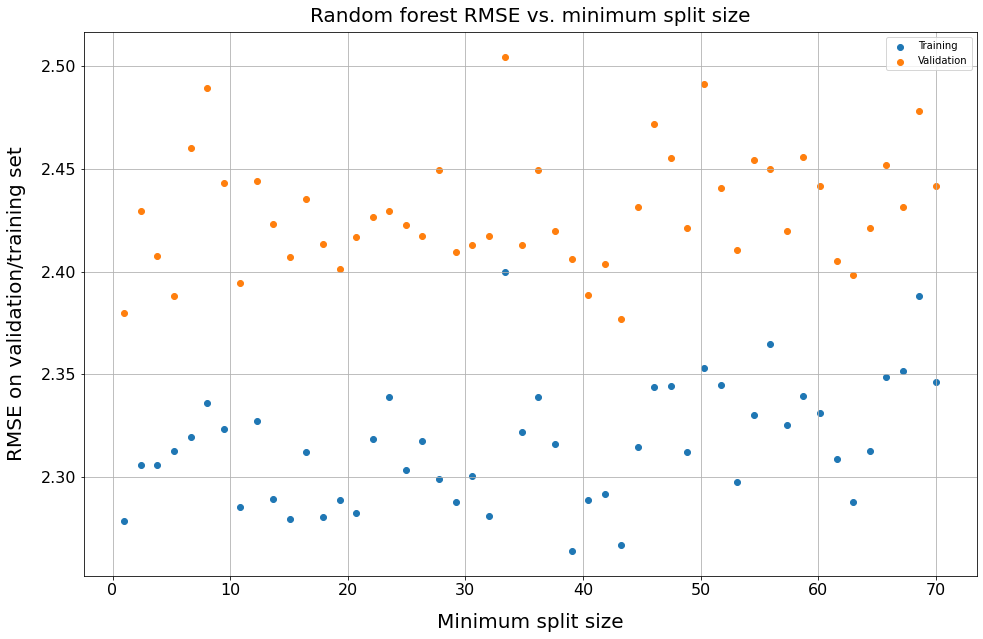

In [374]:
# Tuning random forest...
tuned = l_forest_rand_tuner(train_x, train_y, val_x, val_y, num_samples=5, num_searches=50)

best_hypers = tuned[0]
rf_rmse_trn_list = tuned[1]
rf_rmse_val_list = tuned[2]
min_split_list = tuned[3]

fig = plt.figure(figsize=(16,10))
plt.ylabel('RMSE on validation/training set', fontsize=20, labelpad=15)
plt.xlabel('Minimum leaf size', fontsize=20, labelpad=15)
plt.title('Random forest RMSE vs. minimum leaf size', fontsize=20, pad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.plot(min_split_list, rf_rmse_trn_list, label='Training')
plt.plot(min_split_list, rf_rmse_val_list, label='Validation')
plt.legend()
plt.savefig('RF_ml_tuned_line.png', bbox_inches='tight')
plt.show()

In [327]:
t1 = time.time()
# Tuning random forest...
tuned = s_forest_rand_tuner(train_x, train_y, val_x, val_y, num_samples=5, num_searches=30)
t2 = time.time()

best_hypers = tuned[0]
depth_list = tuned[1]
min_split_list = tuned[2]
min_leaf_list = tuned[3]

delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nHyperparameters tuned in {} mins and {} seconds!'.format(mins, secs))
print(best_hypers.items())

t1 = time.time()
forest = forest_train(train_x, train_y, num_samples=50, max_depth=best_hypers['depth'], \
                              ftr_sampling=True, min_split_size=best_hypers['min_split'], \
                      min_leaf_size=best_hypers['min_leaf'])
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nTuned forest trained in {} mins and {} seconds!'.format(mins, secs))

test_predictions = forest_predict(forest, test_x)
# Finding average prediction...
test_prediction = np.mean(test_predictions, axis=0)
# Calculating performance...
performance(test_prediction, test_y)

Search number: 1
New params = 7 0.0031978065387873855 8.782308922462825
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.7317999616751782
RMSE = 2.511129305171954
R-Squared = 0.5359477282467485
New best RMSE: 2.511129305171954
Search number: 2
New params = 7 0.004225059230982642 63.322556504283384
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.7461573899562852
RMSE = 2.5204641145383464
R-Squared = 0.5324912029137892
Search number: 3
New params = 7 0.0029938205158809308 39.16348910088752
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.757505708823173
RMSE = 2.5393842144765397
R-Squared = 0.5254460621419048
Search number: 4
New params = 7 0.007998428442552141 4.399243976244067
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
MAE = 1.8699824292375113
RMSE = 2.6537442373475275
R-Squared = 0.48174096911990805
Search number: 5
New params = 6 3.655591640208401e-05

### Hyperparameter fine tuning...

In [27]:
def forest_fine_tuner(train_x, train_y, val_x, val_y, num_samples, depth, min_split, min_leaf, num_searches=10):
    best = {'RMSE': np.inf}
    for rand_search in range(num_searches):
        print('Search number:', rand_search + 1)
        min_split = min_split * np.random.rand()*10**np.random.choice([0.0,1.0])
        min_leaf = min_leaf * (np.random.rand() * 2)
        print('New params =', depth, min_split, min_leaf)
        # Training random forest with specific hyperparameters using validation set...
        forest = forest_train(train_x, train_y, num_samples=num_samples, max_depth=depth, \
                              ftr_sampling=True, min_split_size=min_split, min_leaf_size=min_leaf, print_progress = True)
        # Testing hyperparameters using validation set...
        # Predicting validation y-values...
        val_predictions = forest_predict(forest, val_x)

        # Finding average prediction...
        val_prediction = np.mean(val_predictions, axis=0)

        # Calculating prediction accuracy...
        #val_MAE = np.abs((val_y - val_prediction)).mean()
        val_RMSE = np.sqrt(((val_y - val_prediction)**2).mean())
        
         # Find best hyperparameters...
        if val_RMSE < best['RMSE']:
            print('New best RMSE:', val_RMSE)
            best = {'RMSE' : val_RMSE,
                    'depth' : depth,
                    'min_split' : min_split,
                    'min_leaf' : min_leaf}
    return best

#### Running fine tuner

In [70]:
# Measure training time...
t1 = time.time()

# Training random forest...
fine_hypers = forest_fine_tuner(train_x, train_y, val_x, val_y, num_samples=5, depth=best_hypers['depth'], \
                              min_split=best_hypers['min_split'], \
                      min_leaf=best_hypers['min_leaf'], num_searches=30)

t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nHyperparameters fine-tuned in {} mins and {} seconds!'.format(mins, secs))
print(fine_hypers.items())

t1 = time.time()
forest = forest_train(train_x, train_y, num_samples=50, max_depth=fine_hypers['depth'], \
                              ftr_sampling=True, min_split_size=fine_hypers['min_split'], \
                      min_leaf_size=fine_hypers['min_leaf'])
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nFine-tuned forest trained in {} mins and {} seconds!'.format(mins, secs))

test_predictions = forest_predict(forest, test_x)
# Finding average prediction...
test_prediction = np.mean(test_predictions, axis=0)
# Calculating prediction accuracy...
test_MAE = np.abs((test_y - test_prediction)).mean()
test_RMSE = np.sqrt(((test_y - test_prediction)**2).mean())
print('Test MAE =', test_MAE)
print('Test RMSE =', test_RMSE)

Search number: 1
New params = 10 7.364242213996433e-05 5.0511978300371725
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
New best RMSE: 2.4479606405099092
Search number: 2
New params = 10 0.00044212945662473806 9.027763140181484
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
Search number: 3
New params = 10 0.00014251977068390512 6.1868333919644565
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
Search number: 4
New params = 10 0.00012064495879962495 8.398579041975493
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
Search number: 5
New params = 10 6.0625394362214105e-05 4.387809219399246
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
Search number: 6
New params = 10 2.7071824199469547e-05 7.187798698154481
Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained
Search number: 7
New params = 10 2.9637839758266086e-05 14.260060041360

In [287]:
# Measure training time...
t1 = time.time()

forest = forest_train(train_x, train_y, num_samples=5, max_depth=10, \
                              ftr_sampling=True, min_split_size=2e-5, min_leaf_size=1)
t2 = time.time()
delta_t = t2-t1
mins = int(delta_t//60)
secs = delta_t - (60*mins)
print('\nForest trained in {} mins and {} seconds!'.format(mins, secs))

test_predictions = forest_predict(forest, test_x)

# Finding average prediction...
test_prediction = np.mean(test_predictions, axis=0)

# Calculating prediction accuracy...
test_MAE = np.abs((test_y - test_prediction)).mean()
test_RMSE = np.sqrt(((test_y - test_prediction)**2).mean())
test_R2 = 1 - (np.sum((test_y - test_prediction)**2) / np.sum((test_y - np.mean(test_y))**2))
print('Test MAE =', test_MAE)
print('Test RMSE =', test_RMSE)
print('Test R-Squared =', test_R2)

Tree 1 trained
Tree 2 trained
Tree 3 trained
Tree 4 trained
Tree 5 trained

Forest trained in 2 mins and 50.48136258125305 seconds!
Test MAE = 1.5247079218323176
Test RMSE = 2.3388160822810993
Test R-Squared = 0.5924735917855072


## K-Nearest Neighbours

In [396]:
def find_distance(obs, train_x):
    '''
    ========================================
    Input
    ========================================
    obs: Row in test/validation set
    train_x: matrix of train set
    
    ========================================
    Output
    ========================================
    1D numpy array of distances between the single observation and all observations in train_x
    '''
    try:
        return np.sqrt(np.sum(np.square(train_x - obs), axis=1))
    except:
        return np.abs(train_x - obs)

In [397]:
def find_neighbours(obs, train_x, train_y, k):
    '''
    ========================================
    Input
    ========================================
    obs: Row in test/validation set
    train_x: matrix of train set
    k: Number of nearest neighbours to include
    
    ========================================
    Output
    ========================================
    K nearest neighbours as a tuple of their actual y-values and distances
    '''
    k -= 1
    num_obs = train_y.shape[0]
    distances = find_distance(obs, train_x).reshape(num_obs,1)
    y_distances = np.append(train_y.reshape(num_obs,1), distances, axis=1)
    unsorted_nearest = y_distances[np.argpartition(y_distances[:,-1],k)][:k+1]
    k_nearest = unsorted_nearest[unsorted_nearest[:,-1].argsort()]
    return k_nearest[:,0], k_nearest[:,1]

In [398]:
def knn_predict(obs, train_x, train_y, k, weighted):
    nearest = find_neighbours(obs, train_x, train_y, k)
    
    if weighted == False:
        return np.mean(nearest[0])
    
    distances = nearest[1]
    distances = np.where(distances==0, 1e-10, distances)
    return np.average(nearest[0], weights=(1 /(1e-6 + distances)))

In [399]:
def knn(test_x, train_x, train_y, k, weighted=True):
    predictions = []
    for obs in test_x:
        predictions.append(knn_predict(obs, train_x, train_y, k, weighted))
    return np.array(predictions)

### KNN on toy problem...

0.0 mins and 0.2695448398590088 seconds
MAE = 0.0002941443532137703
RMSE = 0.0009056056755815938
R-Squared = 0.9999998487755583
(1500,)


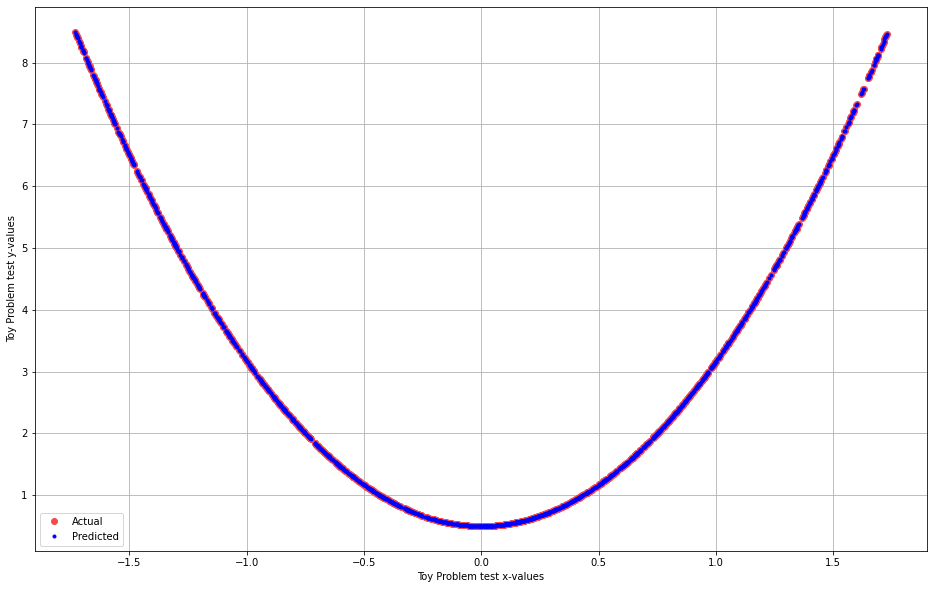

In [402]:
# Running KNN...
t1 = time.time()
KNN_predictions = knn(toy_tst_x, toy_x, toy_y, k=2, weighted=True)

# Printing time taken...
t2 = time.time()
delta_t = t2-t1
mins = delta_t//60
secs = delta_t - (mins*60)
print('{} mins and {} seconds'.format(mins, secs))

# Printing performance...
performance(KNN_predictions, toy_tst_y)
print(toy_tst_x.shape)
# Plotting graph of predicted vs true y-values...
plt.figure(figsize=(16,10))
plt.ylabel('Toy Problem test y-values')
plt.xlabel('Toy Problem test x-values')
plt.grid()
plt.plot(toy_tst_x, toy_tst_y, '#f74a4a', marker='o', linestyle='', label='Actual')
plt.plot(toy_tst_x, KNN_predictions, 'b.', label='Predicted')
plt.legend()
plt.savefig('knn_toy.png', bbox_inches='tight')
plt.show()

### KNN to predict crop yield...

In [117]:
# Running KNN...
t1 = time.time()
KNN_predictions = knn(test_x, train_x, train_y, k=13, weighted=True)

# Printing time taken...
t2 = time.time()
delta_t = t2-t1
mins = delta_t//60
secs = delta_t - (mins*60)
print('{} mins and {} seconds'.format(mins, secs))

# Printing performance...
performance(KNN_predictions, test_y)

0.0 mins and 19.60812258720398 seconds
MAE = 1.2346764696726011
RMSE = 2.0394115175495227
R-Squared = 0.6806789848835948


### Tuning the KNN...

In [405]:
def tune_knn_grid(val_x, val_y, train_x, train_y, max_k=25):
    best = {'RMSE' : np.inf}
    k = np.arange(1, max_k + 1)
    weighted = [True,False]
    rmse_list = []
    for i in range(max_k):
        for j, w in enumerate(weighted):
            print('Iteration number:', (2*i)+j+1)
            val_predicts = knn(val_x, train_x, train_y, k[i], w)
            RMSE = np.sqrt(((val_y - val_predicts)**2).mean())
            rmse_list.append(RMSE)
            print(performance(val_predicts, val_y))
            if RMSE < best['RMSE']:
                best = {'RMSE' : RMSE, 'k' : k[i], 'weighted' : w}
                print('New best:', best)
    return best, rmse_list, k

In [439]:
def tune_knn_rand(val_x, val_y, train_x, train_y, num_iters=25):
    best = {'RMSE' : np.inf}
    k = np.random.randint(1,50,size=num_iters)
    weighted = np.random.choice([True,False], size=num_iters)
    rmse_list = []
    for i in range(num_iters):
        print('Iteration number:', i+1)
        val_predicts = knn(val_x, train_x, train_y, k[i], weighted[i])
        RMSE = np.sqrt(((val_y - val_predicts)**2).mean())
        rmse_list.append(RMSE)
        if RMSE < best['RMSE']:
            best = {'RMSE' : RMSE, 'k' : k[i], 'weighted' : weighted[i]}
            print('New best:', best)
    return best, rmse_list, k, weighted

Iteration number: 1
MAE = 1.4186895025295108
RMSE = 2.319560866365449
R-Squared = 0.6040500462330132
None
New best: {'RMSE': 2.319560866365449, 'k': 1, 'weighted': True}
Iteration number: 2
MAE = 1.4186895025295112
RMSE = 2.319560866365449
R-Squared = 0.6040500462330132
None
Iteration number: 3
MAE = 1.3240962730666417
RMSE = 2.1602832246943686
R-Squared = 0.6565605841164296
None
New best: {'RMSE': 2.1602832246943686, 'k': 2, 'weighted': True}
Iteration number: 4
MAE = 1.3423616146711634
RMSE = 2.151180899379939
R-Squared = 0.6594486419121334
None
New best: {'RMSE': 2.151180899379939, 'k': 2, 'weighted': False}
Iteration number: 5
MAE = 1.2915618006573542
RMSE = 2.10518201015296
R-Squared = 0.6738570083475124
None
New best: {'RMSE': 2.10518201015296, 'k': 3, 'weighted': True}
Iteration number: 6
MAE = 1.321482785272625
RMSE = 2.1001658842141437
R-Squared = 0.6754093921813502
None
New best: {'RMSE': 2.1001658842141437, 'k': 3, 'weighted': False}
Iteration number: 7
MAE = 1.2718635678705

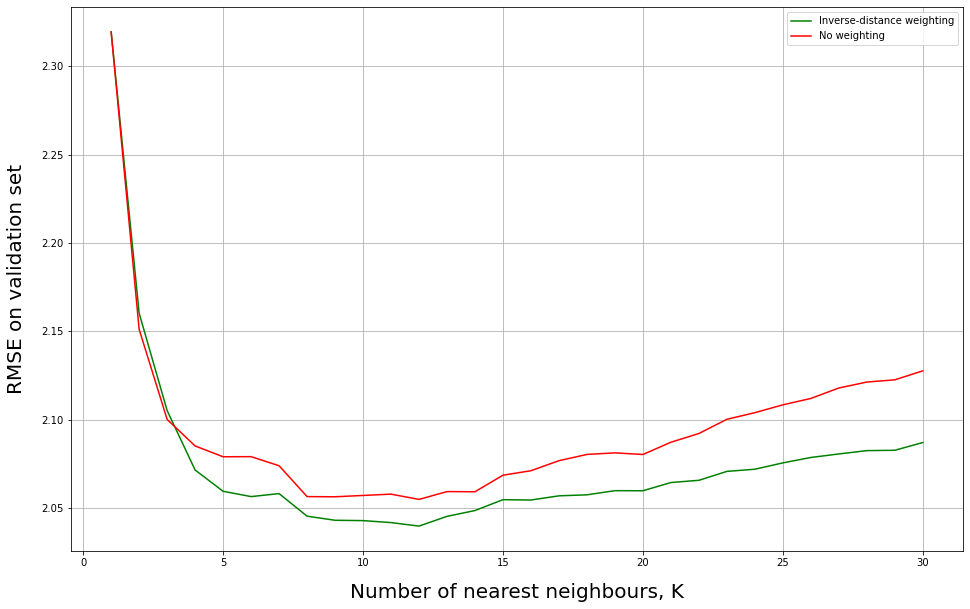

In [406]:
# Tuning KNN with grid search...
t1 = time.time()
tuned = tune_knn_grid(val_x, val_y, train_x, train_y, max_k=30)

# Printing time taken...
t2 = time.time()
delta_t = t2-t1
mins = delta_t//60
secs = delta_t - (mins*60)
print('{} mins and {} seconds'.format(mins, secs))

best = tuned[0]
print(best)

# Plotting RMSE vs k...
rmse_arr = np.array(tuned[1])
k = tuned[2]
evens = [n for n in np.arange(rmse_arr.size) if (n%2)==0]
odds = [n for n in np.arange(rmse_arr.size) if (n%2)!=0]

plt.figure(figsize=(16,10))
plt.ylabel('RMSE on validation set', fontsize=20, labelpad=15)
plt.xlabel('Number of nearest neighbours, K', fontsize=20, labelpad=15)
plt.grid()
plt.plot(k, rmse_arr[evens], 'g', label='Inverse-distance weighting')
plt.plot(k, rmse_arr[odds], 'r', label='No weighting')
plt.legend()
plt.savefig('knn_hypers_new.png', bbox_inches='tight')
plt.show()

In [297]:
# Tuning KNN with random search...
t1 = time.time()
tuned = tune_knn_rand(val_x, val_y, train_x, train_y, num_iters=20)

# Printing time taken...
t2 = time.time()
delta_t = t2-t1
mins = delta_t//60
secs = delta_t - (mins*60)
print('{} mins and {} seconds'.format(mins, secs))

best = tuned[0]
print(best)

# Plotting RMSE vs k...
rmse_arr = np.array(tuned[1])
k_rmse = np.append(tuned[2].reshape(tuned[2].size,1), rmse_arr.reshape(rmse_arr.size,1), axis=1)
argsort = k_rmse[:,0].argsort()
k_rmse = k_rmse[argsort]
sorted_w = tuned[3][argsort]
k_rmse[np.invert(sorted_w),:]

plt.figure(figsize=(16,10))
plt.plot(k_rmse[sorted_w, 0], k_rmse[sorted_w, 1], 'g')
plt.plot(k_rmse[np.invert(sorted_w),0], k_rmse[np.invert(sorted_w),1], 'r')
plt.show()

Iteration number: 1
New best: {'RMSE': 2.424776802082197, 'k': 1, 'weighted': True}
Iteration number: 2
Iteration number: 2
New best: {'RMSE': 2.1936117724736035, 'k': 2, 'weighted': True}
Iteration number: 3
New best: {'RMSE': 2.168190326084417, 'k': 2, 'weighted': False}
1.0 mins and 20.876224994659424 seconds
{'RMSE': 2.168190326084417, 'k': 2, 'weighted': False}


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 4

## Gaussian Proccess Regression

### Vectorised kernel function...

In [17]:
def gp_vect_kernel(X, length_scale, sigma_f, X2=None):
    '''
    Defining the radial basis function (squared exponential kernel) for a given length-scale and signal varaince (sigma_f)
    (VECTORISED)
    ========================================
    Input
    ========================================
    X: All observations (2D numpy array)
    length_scale: Alters spread of covariance - a hyper parameter
    sigma_f: Signal variance (variance in f(x)) - a hyper parameter
    
    ========================================
    Output
    ========================================
    Covariance matrix (2D numpy array)
    '''
    if X2 is None:
        if X.ndim == 1:
            X_norm = np.square(np.linalg.norm(X))
            distances = X_norm.reshape(-1, 1) + X_norm.reshape(1, -1) - 2*np.dot(X, X.T)
        else:
            X_norm = np.square(np.linalg.norm(X, axis=1))
            distances = X_norm.reshape(-1, 1) + X_norm.reshape(1, -1) - 2*np.dot(X, X.T)
    else:
        if X.ndim == 1:
            X1_norm = np.square(np.linalg.norm(X))
            X2_norm = np.square(np.linalg.norm(X2))
            distances = X1_norm.reshape(-1, 1) + X2_norm.reshape(1, -1) - 2*np.matmul(X.reshape(-1, 1), X2.reshape(1, -1))
        else:
            X1_norm = np.square(np.linalg.norm(X, axis=1))
            X2_norm = np.square(np.linalg.norm(X2, axis=1))
            distances = X1_norm.reshape(-1, 1) + X2_norm.reshape(1, -1) - 2*np.dot(X, X2.T)
    
    arg = distances / (2*(length_scale**2))
    return (sigma_f**2) * np.exp(-arg)

## The posterior

### Calculating mean function predictions...

In [18]:
def gp_alpha_inv(cov_X, sigma_e, n_train):
    I = np.identity(n_train)
    
    # Adding noise...
    alpha = cov_X + (sigma_e * I)
    
    # Using Cholesky decomposition to speed up matrix inversion...
    return sp.linalg.cho_solve(sp.linalg.cho_factor(alpha), I)  # np.linalg.inv(alpha)

In [19]:
def gp_vect_predict(X, X_test, y_train, length_scale, sigma_f, sigma_e):
    
    # Calculating covaraince matrices...
    cov_X = gp_vect_kernel(X, length_scale, sigma_f)
    cov_X_Xt = gp_vect_kernel(X, length_scale, sigma_f, X2=X_test)
    
    # Calculating matrix inverse...
    n_train = X.shape[0]
    inv_alpha = gp_alpha_inv(cov_X, sigma_e, n_train)
    
    # Calculating mean function...
    inv_alpha_y = np.matmul(inv_alpha, y_train.reshape(n_train,1))
    return np.matmul(cov_X_Xt.T, inv_alpha_y).reshape(X_test.shape[0])

### Calculating posterior distribution (both mean and covariance)...

In [20]:
def post_covars(X, X_test, length_scale, sigma_f):
    '''
    Generates posterior covariance matrices.
    ========================================
    Input
    ========================================
    X: Matrix of train observations
    X_test: Matrix of test observations
    length_scale: Alters spread of covariance - a hyper parameter
    sigma_f: Signal variance (variance in f(x)) - a hyper parameter
    
    ========================================
    Output
    ========================================
    Posterior covariance matrices (3 numpy arrays)
    '''
    cov_X = gp_vect_kernel(X, length_scale, sigma_f)
    cov_X_Xt = gp_vect_kernel(X, length_scale, sigma_f, X2=X_test)
    cov_Xt = gp_vect_kernel(X_test, length_scale, sigma_f)
    return cov_X, cov_X_Xt, cov_Xt

In [21]:
def postior_mean(cov_X_Xt, cov_X, y_train, inv_alpha, sigma_e, n_train, n_test):
    inv_alpha_y = np.matmul(inv_alpha, y_train.reshape(n_train,1))
    return np.matmul(cov_X_Xt.T, inv_alpha_y).reshape(n_test)

In [22]:
def postior_covar(cov_Xt, cov_X_Xt, cov_X, inv_alpha, sigma_e, n_train):
    return cov_Xt - np.matmul(cov_X_Xt.T, np.matmul(inv_alpha, cov_X_Xt))

In [23]:
def post_dist(X, X_test, y_train, length_scale, sigma_f, sigma_e):
    
    # Calculating covariance matrices...
    covars = post_covars(X, X_test, length_scale, sigma_f)
    cov_X = covars[0]
    cov_X_Xt = covars[1]
    cov_Xt = covars[2]
    
    # Calculating posterior mean and covariance matrix...
    n_train = X.shape[0]
    n_test = X_test.shape[0]
    inv_alpha = gp_alpha_inv(cov_X, sigma_e, n_train)
    mean = postior_mean(cov_X_Xt, cov_X, y_train, inv_alpha, sigma_e, n_train, n_test)
    covar = postior_covar(cov_Xt, cov_X_Xt, cov_X, inv_alpha, sigma_e, n_train)
    
    # Returning the posterior distribution...
    return mean, covar

### Implementing GP on toy problem...

MAE = 0.001989031005743449
RMSE = 0.0022346245689019513
R-Squared = 0.9999990792264034


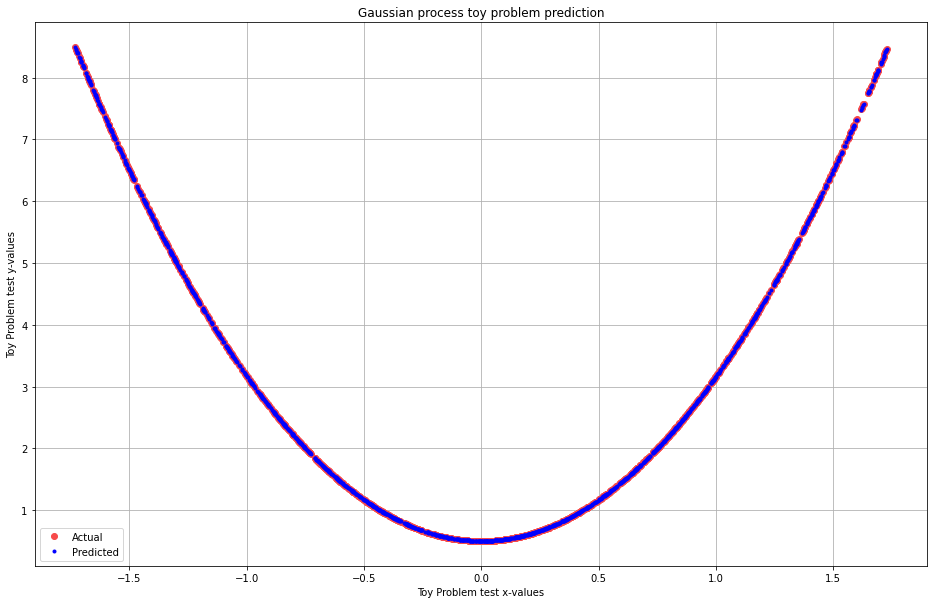

In [26]:
gp_preds = gp_vect_predict(toy_x.reshape(toy_x.shape[0],1), toy_tst_x.reshape(toy_tst_x.shape[0],1), toy_y, 1, 1, sigma_e=1e-10)

# Printing performance...
performance(gp_preds, toy_tst_y)

# Plotting graph of predicted vs true y-values...
plt.figure(figsize=(16,10))
plt.ylabel('Toy Problem test y-values')
plt.xlabel('Toy Problem test x-values')
plt.grid()
plt.plot(toy_tst_x, toy_tst_y, '#f74a4a', marker='o', linestyle='', label='Actual')
plt.plot(toy_tst_x, gp_preds, 'b.', label='Predicted')
plt.legend()
plt.title('Gaussian process toy problem prediction')
#plt.savefig('gp_toy.png', bbox_inches='tight')
plt.show()

In [440]:
# Generating features...
n_obs = 1200

alpha = np.linspace(-2.5*np.pi, 2.5*np.pi, n_obs).reshape(n_obs,1)
beta = np.linspace(-2.5, 2.5, n_obs).reshape(n_obs,1)
x = np.hstack((alpha, beta))

y = 2*np.sin(alpha) + beta

# Standardising features...
x = standardise_data(x)[0]

# Randomly shuffling observations...
np.random.seed(2)
shuffle = np.random.permutation(800)
t_x = x[200:1000][shuffle]
t_y = y[200:1000][shuffle]

# Splitting into train and test sets...
# Train...
split = 700
toy_x = t_x[:split, :]
toy_y = t_y[:split]
# Test...
np.random.seed(3)
shuffle = np.random.permutation(np.arange(0,200))
toy_tst_x = np.vstack((np.vstack((t_x[split:, :], x[:200][shuffle][:50, :])), x[1000:][shuffle][:50, :]))
toy_tst_y = np.vstack((np.vstack((t_y[split:], y[:200][shuffle][:50])), y[1000:][shuffle][:50]))
toy_tst_y = toy_tst_y.reshape(toy_tst_y.shape[0])

In [444]:
print(toy_tst_x.shape)

(200, 2)


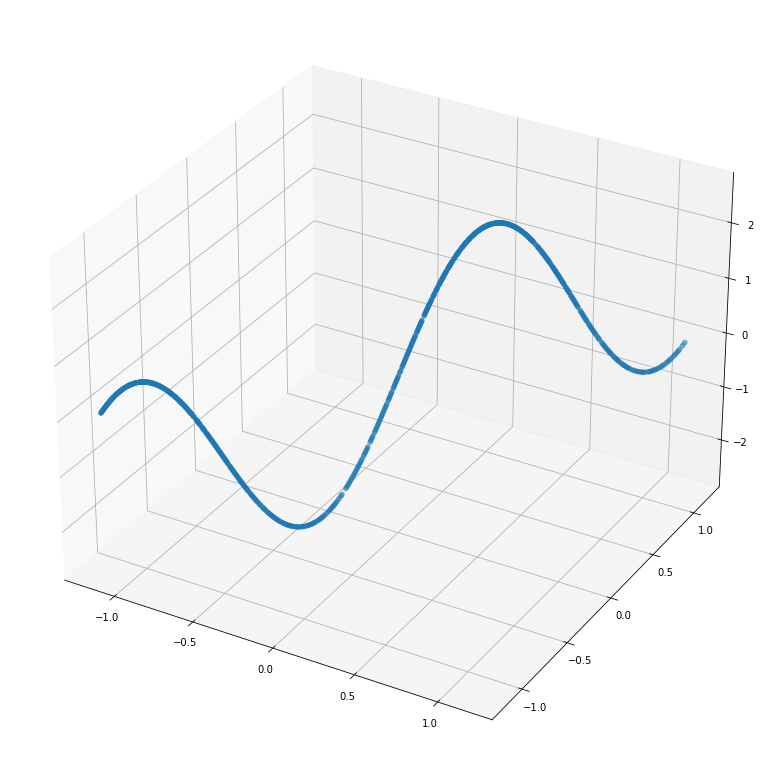

In [441]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_x[:,0].reshape(700), ys=toy_x[:,1].reshape(700), zs=toy_y)
plt.show()

Total time: 0 mins and 0.09 seconds
MAE = 0.0071704353714381166
RMSE = 0.01728107801261001
R-Squared = 0.9999442665525287


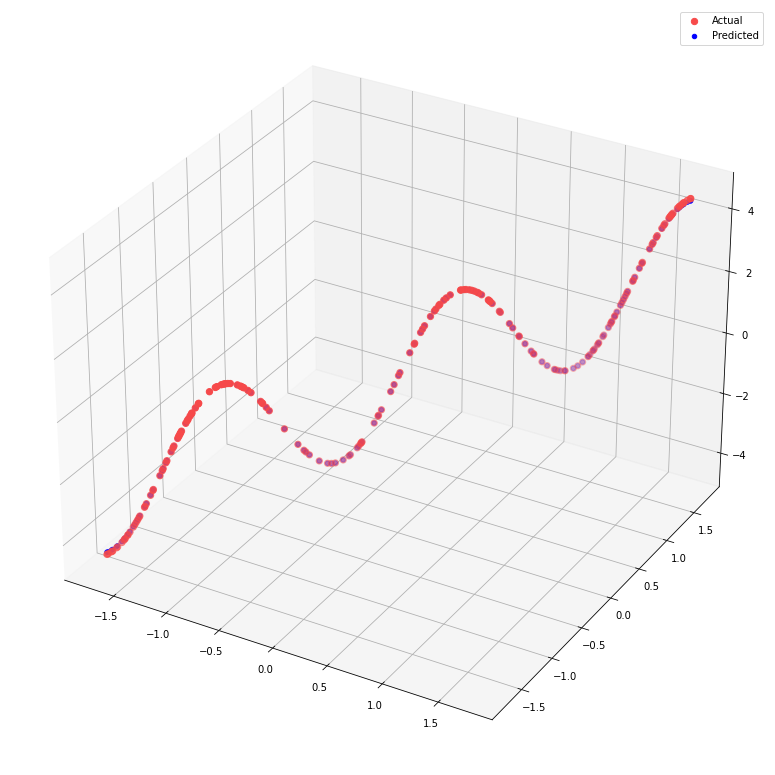

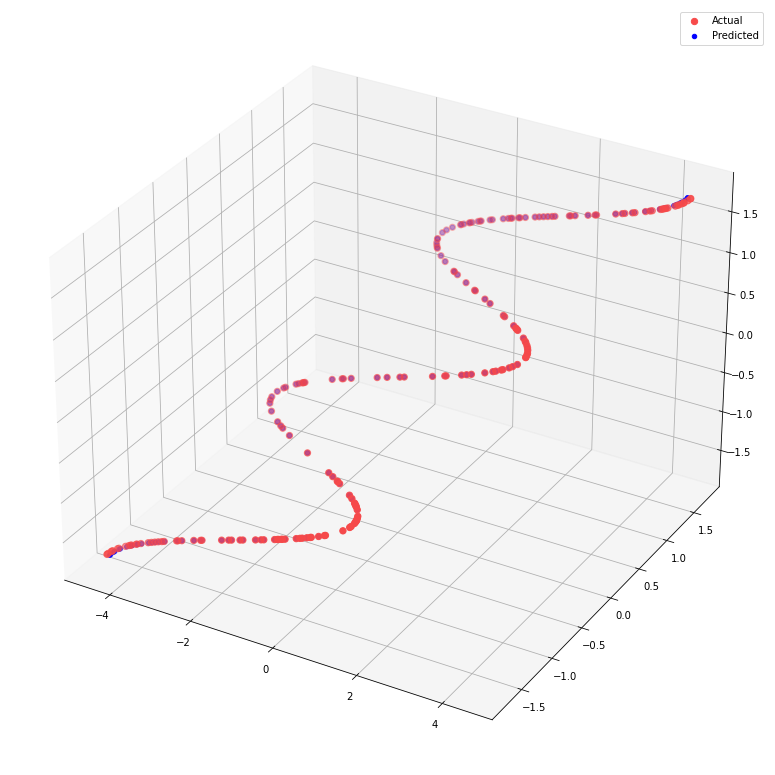

In [442]:
n_train = toy_x.shape[0]
t1 = time.time()
gp_preds = gp_vect_predict(toy_x, toy_tst_x, toy_y, 1, 1, sigma_e=1e-10)

# Printing time taken...
t3 = time.time()
delta_t3 = t3-t1
mins_3 = delta_t3//60
secs_3 = delta_t3 - (mins_3*60)
print('Total time: {} mins and {} seconds'.format(int(mins_3), round(secs_3, 2)))

# Printing performance...
performance(gp_preds, toy_tst_y)

# Plotting graph of predicted vs true y-values...
'''
plt.figure(figsize=(16,10))
plt.ylabel('Toy Problem test y-values')
plt.xlabel('Toy Problem test x-values')
plt.grid()
plt.plot(toy_tst_x, toy_tst_y, '#f74a4a', marker='o', linestyle='', label='Actual')
plt.plot(toy_tst_x, gp_preds, 'b.', label='Predicted')
plt.legend()
plt.show()
'''
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_x[:,0].reshape(200), ys=toy_tst_x[:,1].reshape(200), zs=toy_tst_y, c='#f74a4a', s=40, label='Actual')
ax.scatter(xs=toy_tst_x[:,0].reshape(200), ys=toy_tst_x[:,1].reshape(200), zs=gp_preds, c='b', label='Predicted')
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_y, ys=toy_tst_x[:,1].reshape(200), zs=toy_tst_x[:,0].reshape(200), c='#f74a4a', s=40, label='Actual')
ax.scatter(xs=gp_preds, ys=toy_tst_x[:,1].reshape(200), zs=toy_tst_x[:,0].reshape(200), c='b', label='Predicted')
plt.legend()
plt.show()

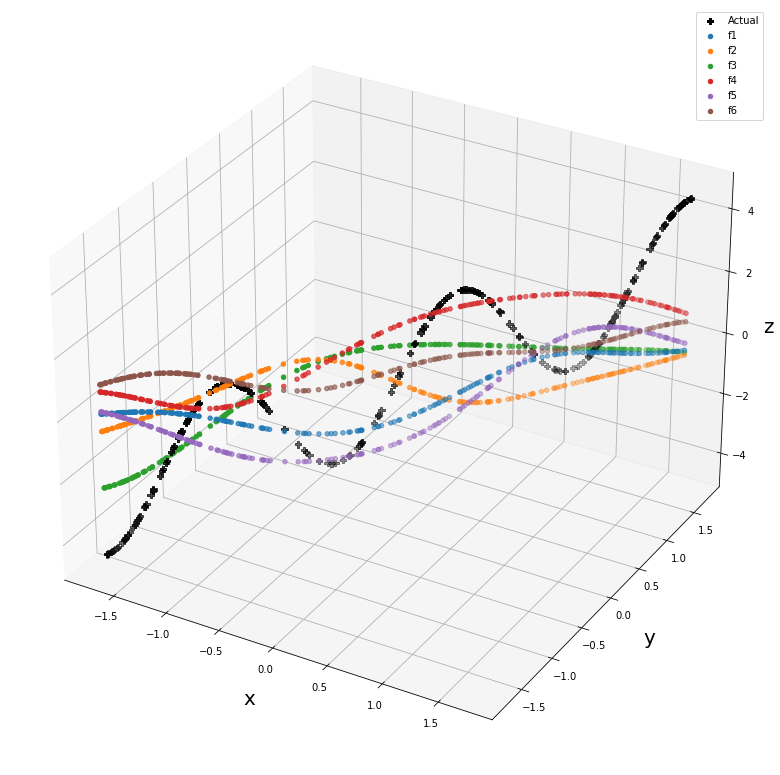

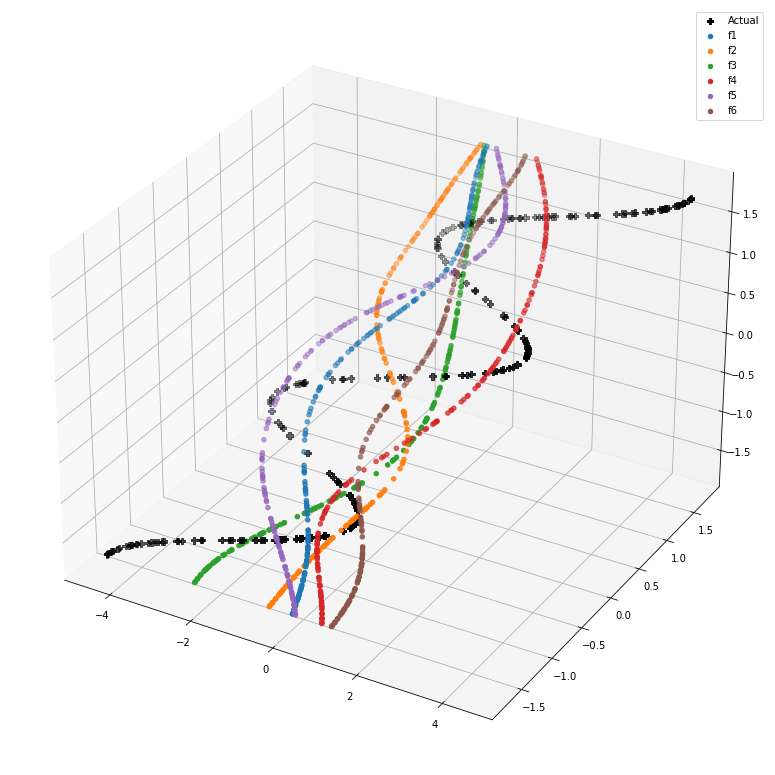

In [295]:
n_funcs = 6
n_obs = toy_tst_x.shape[0]

prior_mean = np.zeros(n_obs)
prior_cov = prior_covar(toy_tst_x, 1, 1.05, n=n_obs)

prior_y_samples = np.random.multivariate_normal(prior_mean, cov=prior_cov, size=n_funcs)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[0], label='f1')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[1], label='f2')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[2], label='f3')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[3], label='f4')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[4], label='f5')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=prior_y_samples[5], label='f6')
plt.xlabel('x', fontsize=20, labelpad=15)
plt.ylabel('y', fontsize=20, labelpad=15)
ax.set_zlabel('z', fontsize=20, labelpad=5)
plt.legend()
#plt.savefig('prior_funcs.png', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[0], label='f1')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[1], label='f2')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[2], label='f3')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[3], label='f4')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[4], label='f5')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=prior_y_samples[5], label='f6')
plt.legend()
plt.show()

<ipython-input-297-a20b83311a53>:8: RuntimeWarning: covariance is not positive-semidefinite.
  post_y_samples = np.random.multivariate_normal(postr_mean, cov=postr_cov, size=n_funcs)


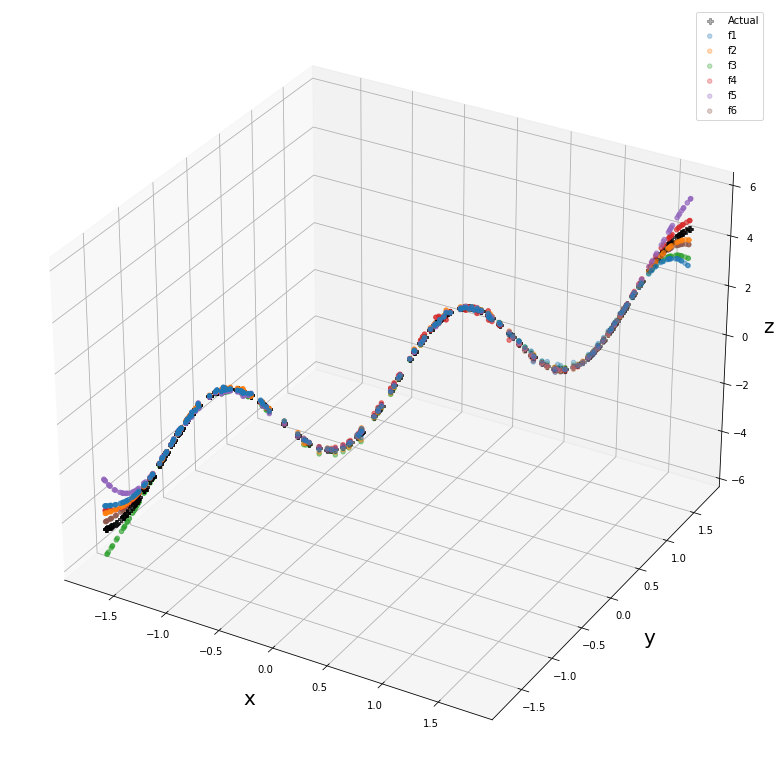

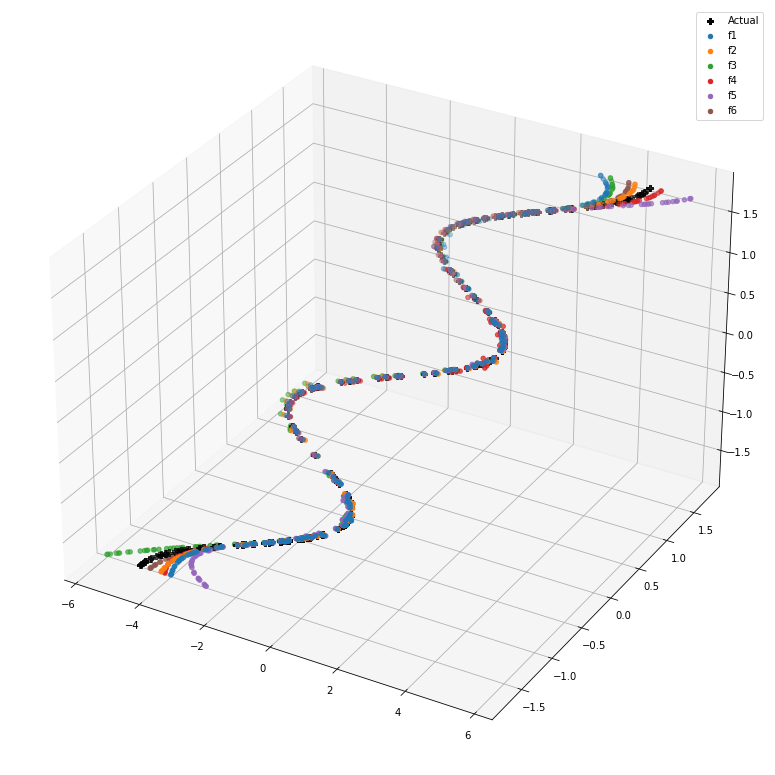

In [297]:
n_funcs = 6
n_obs = toy_tst_x.shape[0]

posterior_distribution = post_dist(toy_x, toy_tst_x, toy_y, length_scale=0.4, sigma_f=2.5, sigma_e=1e-10)
postr_mean = posterior_distribution[0]
postr_cov = posterior_distribution[1]

post_y_samples = np.random.multivariate_normal(postr_mean, cov=postr_cov, size=n_funcs)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[0], label='f1')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[1], label='f2')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[2], label='f3')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[3], label='f4')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[4], label='f5')
ax.scatter(xs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), zs=post_y_samples[5], label='f6')
plt.xlabel('x', fontsize=20, labelpad=15)
plt.ylabel('y', fontsize=20, labelpad=15)
ax.set_zlabel('z', fontsize=20, labelpad=5)
plt.savefig('post_funcs.png', bbox_inches='tight')
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=toy_tst_y, label='Actual', \
           marker='P', color='#000000', s=40)
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[0], label='f1')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[1], label='f2')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[2], label='f3')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[3], label='f4')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[4], label='f5')
ax.scatter(zs=toy_tst_x[:,0].reshape(n_obs), ys=toy_tst_x[:,1].reshape(n_obs), xs=post_y_samples[5], label='f6')
plt.legend()
plt.show()

### Implementing GP to predict crop yield...

### Representative Sampling...
5 random observation samples are selected per 0.1 percentile of training y set, with all of the top 0.5% of extreme y-values included in the sample

In [128]:
import math
def strat_samples(train_x, train_y, num_percentiles=1000, num_sub_samples=5, max_perc=100):
    
    # Finding percentile bands (up to 99.5th percentile)...
    percentiles = np.percentile(train_y, np.linspace(0, max_perc, num_percentiles))
    prev_percentile = 0
    i = 1
    for percentile in percentiles:
        
        # Getting observations within current percentile...
        samples = train_y > prev_percentile
        sampled_y = train_y[samples]
        sampled_x = train_x[samples]
        samples = sampled_y <= percentile
        sampled_y = sampled_y[samples]
        sampled_x = sampled_x[samples]
        
        y_size = sampled_y.shape[0]
        if y_size <= num_sub_samples:
            if y_size == 0:
                continue
            # Adding to overall sample...
            if i == 1:
                sample_y = sampled_y
                sample_x = sampled_x
                prev_percentile = percentile
                i += 1
                continue
            sample_y = np.append(sample_y, sampled_y)
            sample_x = np.vstack((sample_x, sampled_x))
            prev_percentile = percentile
            i += 1
            continue
        
        # Selecting 5 random observations...
        np.random.seed(1)
        rand_inds = np.random.randint(0,sampled_y.shape[0],size=num_sub_samples)
        sampled_y = sampled_y[rand_inds]
        sampled_x = sampled_x[rand_inds]
        
        # Adding to overall sample...
        if i == 1:
            sample_y = sampled_y
            sample_x = sampled_x
            prev_percentile = percentile
            i += 1
            continue
        
        sample_y = np.append(sample_y, sampled_y)
        sample_x = np.vstack((sample_x, sampled_x))
        
        prev_percentile = percentile
        i += 1
        
    return sample_y, sample_x

In [129]:
# Genrating a representative sample of observations up to the 99.5th percentile
# by taking 5 samples for every 0.1 percentile...
max_perc = 100
samples = strat_samples(train_x, train_y, num_percentiles=1000, num_sub_samples=5, max_perc=max_perc)
sample_y = samples[0]
sample_x = samples[1]

# Adding all observations with crop yields above the 99.5th percentile...
samples = train_y > np.percentile(train_y, max_perc)
sampled_y = train_y[samples]
sampled_x = train_x[samples]

sample_y = np.append(sample_y, sampled_y)
sample_x = np.vstack((sample_x, sampled_x))
print(sample_x.shape[0], 'observations in representative sample')

4990 observations in representative sample


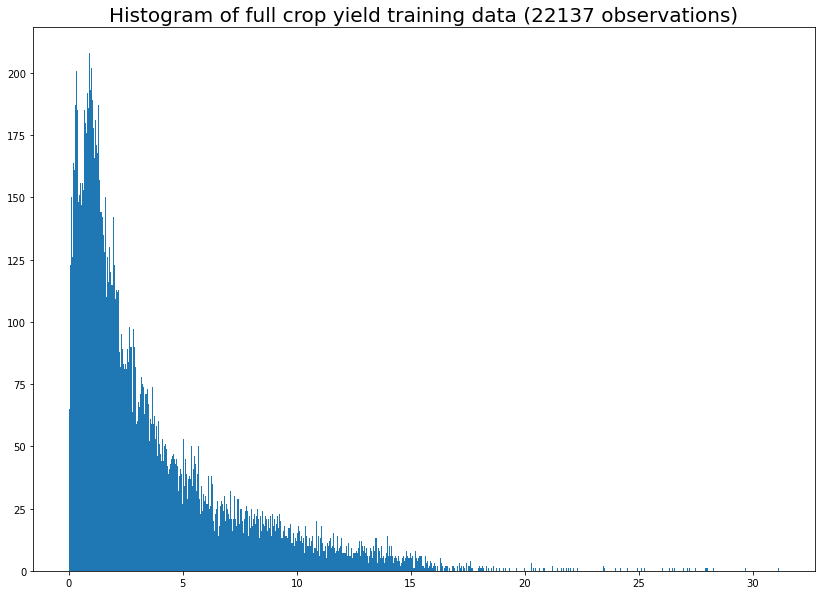

In [130]:
plt.figure(figsize=(14,10))
plt.hist(train_y, bins=1000)
plt.title('Histogram of full crop yield training data ({} observations)'.format(train_y.size), fontsize=20)
plt.show()

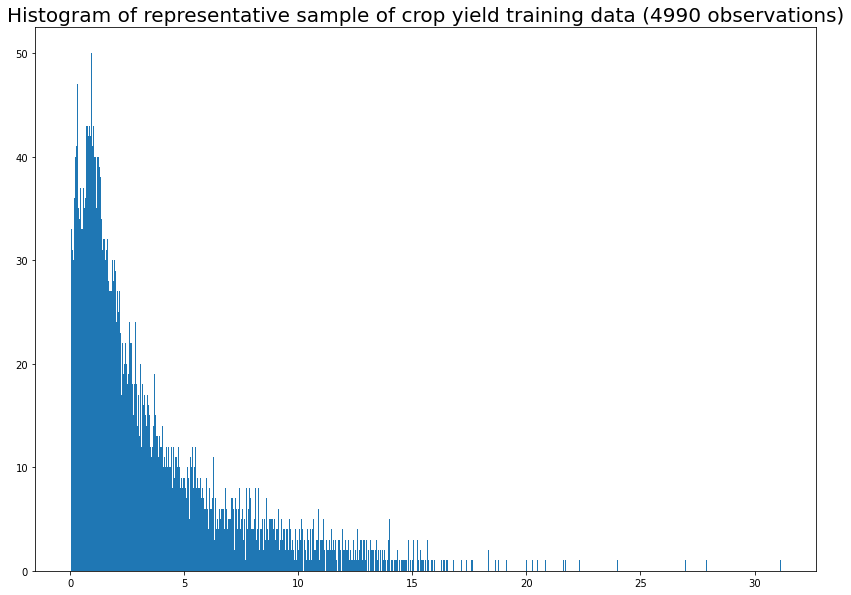

In [131]:
plt.figure(figsize=(14,10))
plt.hist(sample_y, bins=1000) # train_y_sample
plt.title('Histogram of representative sample of crop yield training data ({} observations)'.format(sample_y.size), fontsize=20)
plt.show()

In [132]:
# Generating sub-sample of observations...
# Train observations
np.random.seed(1)
train_shuffle = np.random.randint(0, train_x.shape[0], size=8000) # 5000
train_x_sample = train_x[train_shuffle]
train_y_sample = train_y[train_shuffle]

# Test observations
np.random.seed(2)
test_shuffle = np.random.randint(0, test_x.shape[0], size=2000) # 1000
test_x_sample = test_x[test_shuffle]
test_y_sample = test_y[test_shuffle]

# Validation observations
np.random.seed(1)
val_shuffle = np.random.randint(0, val_x.shape[0], size=2000)
val_x_sample = val_x[val_shuffle]
val_y_sample = val_y[val_shuffle]

## Implimenting GP on crop data with representative sampling...

In [346]:
length_scale = 2.4   # 3.05
sigma_f = 3.2   # 2
sigma_e = 1.83  # 1.83

# Predicting yield values...
t1 = time.time()
gp_predictions = gp_vect_predict(sample_x, val_x_sample, sample_y, length_scale, sigma_f, sigma_e)
t2 = time.time()

# Printing time taken...
delta_t1 = t2-t1
mins_1 = delta_t1//60
secs_1 = delta_t1 - (mins_1*60)
print('Total time: {} mins and {} seconds'.format(int(mins_1), round(secs_1, 2)))

# Printing performance...
performance(gp_predictions, val_y_sample)

Total time: 0 mins and 6.69 seconds
MAE = 1.4659523133615562
RMSE = 2.2079809045747867
R-Squared = 0.627269342207277


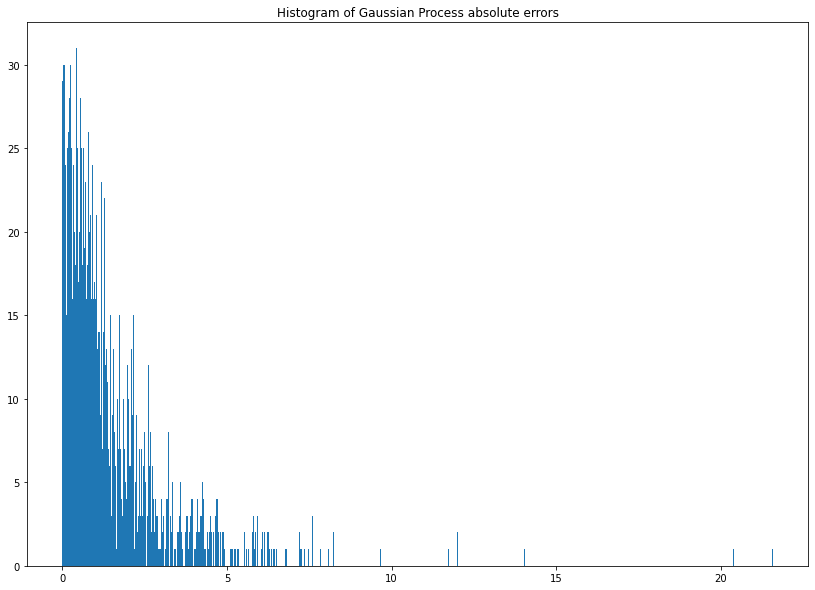

In [142]:
AE = np.abs(gp_predictions - val_y_sample)
plt.figure(figsize=(14,10))
plt.hist(AE, bins=1000)
plt.title('Histogram of Gaussian Process absolute errors')
plt.show()

In [ ]:
'''

-------------------------------------------------------

-------------------------------------------------------
Covariance calculation took 3 mins and 34.05 seconds
Predictions took 1 mins and 25.89 seconds
Total time: 4 mins and 59.93 seconds
MAE = 1.5110202971767424
RMSE = 2.2774817617833945
R-Squared = 0.6502211663295036
-------------------------------------------------------
Covariance calculation took 3 mins and 23.66 seconds
Predictions took 1 mins and 23.47 seconds
Total time: 4 mins and 47.12 seconds
MAE = 1.524298932567734
RMSE = 2.2909528259057215
R-Squared = 0.6460711192456072
-------------------------------------------------------
Covariance calculation took 6 mins and 22.94 seconds
Predictions took 2 mins and 1.65 seconds
Total time: 8 mins and 24.59 seconds
MAE = 1.6028315434103644
RMSE = 2.4412300259074593
R-Squared = 0.5981156304799751
-------------------------------------------------------
n_train = 8200, n_test = 3000 (sample includes all y > 15.5)
l = 3, sigma_f = 2, sigma_e = 1
Covariance calculation took 9 mins and 30.4 seconds
Predictions took 3 mins and 40.17 seconds
Total time: 13 mins and 10.57 seconds

MAE = 1.5169562600619155
RMSE = 2.2402647065633126
R-Squared = 0.640407323749904
---------------------------------------------------------
n_train = 5600, n_test = 1000 (sample includes all y > 17.226)
l = 1.7, sigma_f = 1, sigma_e = 0.5
Covariance calculation took 4 mins and 33.57 seconds
Predictions took 0 mins and 52.53 seconds
Total time: 5 mins and 26.09 seconds

MAE = 1.4660475192750362
RMSE = 2.1847718857919154
R-Squared = 0.6138457253583297
----------------------------------------------------------
n_train = 5200, n_test = 1000 (sample includes all y > 17)
l = 1.7, sigma_f = 1, sigma_e = 0.5
Total time: 4 mins and 44.07 seconds

MAE = 1.4799682084845076
RMSE = 2.2049063256278707
R-Squared = 0.6066954809621237
'''

### Tuning GP hyperparameters...

In [357]:
def tune_gp_rand(val_x, val_y, train_x, train_y, num_iters=10):
    best = {'RMSE' : np.inf}
    l = 2.4*np.ones(num_iters)    # (np.random.rand(num_iters)*5) + 0.4
    sigma_f = 2.98*np.ones(num_iters)   # np.linspace(0.3,5.3, num_iters)
    sigma_e = np.linspace(0.3,5.3, num_iters)     # 1.85*np.ones(num_iters)
    rmse_list = []
    mae_list = []
    r2_list = []
    n_train = train_x.shape[0]
    for i in range(num_iters):
        print('\nIteration number:', i+1)
        print('l = {}, sigma_f = {}, sigma_e = {}'.format(l[i], sigma_f[i], sigma_e[i]))
        
        # Predicting yields...
        t1 = time.time()
        val_predicts = gp_vect_predict(train_x, val_x, train_y, l[i], sigma_f[i], sigma_e[i])
        t2 = time.time()
        
        # Printing time taken...
        delta_t1 = t2-t1
        mins_1 = delta_t1//60
        secs_1 = delta_t1 - (mins_1*60)
        print('Prediction took {} mins and {} seconds'.format(int(mins_1), round(secs_1, 2)))
        
        RMSE = np.sqrt(((val_y - val_predicts)**2).mean())
        rmse_list.append(RMSE)
        MAE = np.abs(val_y - val_predicts).mean()
        mae_list.append(MAE)
        R2 = 1 - (np.sum((val_y - val_predicts)**2) / np.sum((val_y - np.mean(val_y))**2))
        r2_list.append(R2)
        print('MAE =', MAE)
        print('RMSE =', RMSE)
        print('R-Squared =', R2)
        if RMSE < best['RMSE']:
            best = {'RMSE' : RMSE, 'l' : l[i], 'sigma_f' : sigma_f[i], 'sigma_e' : sigma_e[i]}
            print('New best:', best)
    return best, rmse_list, l, sigma_f, sigma_e

In [358]:
print('{} Train observations, {} Validation observations'.format(sample_y.shape[0], val_y_sample.shape[0]))
t1 = time.time()
tuned = tune_gp_rand(val_x_sample, val_y_sample, sample_x, sample_y, num_iters=70)

# Printing time taken...
t2 = time.time()
delta_t = t2-t1
mins = delta_t//60
secs = delta_t - (mins*60)
print('\n{} mins and {} seconds'.format(mins, secs))

best = tuned[0]
print('\nOverall best is...', best)

rmse_list = tuned[1]
#l_list = tuned[2]
#sigma_f_list = tuned[3]
sigma_e_list = tuned[4]

4990 Train observations, 2000 Validation observations

Iteration number: 1
l = 2.4, sigma_f = 2.98, sigma_e = 0.3
Prediction took 0 mins and 4.19 seconds
MAE = 1.494886363225023
RMSE = 2.2697276443396643
R-Squared = 0.6061308335842379
New best: {'RMSE': 2.2697276443396643, 'l': 2.4, 'sigma_f': 2.98, 'sigma_e': 0.3}

Iteration number: 2
l = 2.4, sigma_f = 2.98, sigma_e = 0.372463768115942
Prediction took 0 mins and 4.29 seconds
MAE = 1.4860932821860544
RMSE = 2.2550511947708034
R-Squared = 0.611208017000215
New best: {'RMSE': 2.2550511947708034, 'l': 2.4, 'sigma_f': 2.98, 'sigma_e': 0.372463768115942}

Iteration number: 3
l = 2.4, sigma_f = 2.98, sigma_e = 0.4449275362318841
Prediction took 0 mins and 4.17 seconds
MAE = 1.4805182660179843
RMSE = 2.2446959499063053
R-Squared = 0.6147705014095395
New best: {'RMSE': 2.2446959499063053, 'l': 2.4, 'sigma_f': 2.98, 'sigma_e': 0.4449275362318841}

Iteration number: 4
l = 2.4, sigma_f = 2.98, sigma_e = 0.5173913043478261
Prediction took 0 mins 

Prediction took 0 mins and 4.25 seconds
MAE = 1.4702745888621598
RMSE = 2.208665576779005
R-Squared = 0.6270381464684812

Iteration number: 32
l = 2.4, sigma_f = 2.98, sigma_e = 2.546376811594203
Prediction took 0 mins and 3.98 seconds
MAE = 1.4706250187719105
RMSE = 2.2089359708951584
R-Squared = 0.6269468217655993

Iteration number: 33
l = 2.4, sigma_f = 2.98, sigma_e = 2.618840579710145
Prediction took 0 mins and 3.96 seconds
MAE = 1.4709807262912598
RMSE = 2.2092252293431662
R-Squared = 0.6268491133212913

Iteration number: 34
l = 2.4, sigma_f = 2.98, sigma_e = 2.6913043478260867
Prediction took 0 mins and 3.87 seconds
MAE = 1.4713586284844455
RMSE = 2.2095316530814575
R-Squared = 0.6267455926681045

Iteration number: 35
l = 2.4, sigma_f = 2.98, sigma_e = 2.763768115942029
Prediction took 0 mins and 4.0 seconds
MAE = 1.4717444759691334
RMSE = 2.2098537211443903
R-Squared = 0.6266367713392832

Iteration number: 36
l = 2.4, sigma_f = 2.98, sigma_e = 2.836231884057971
Prediction took 

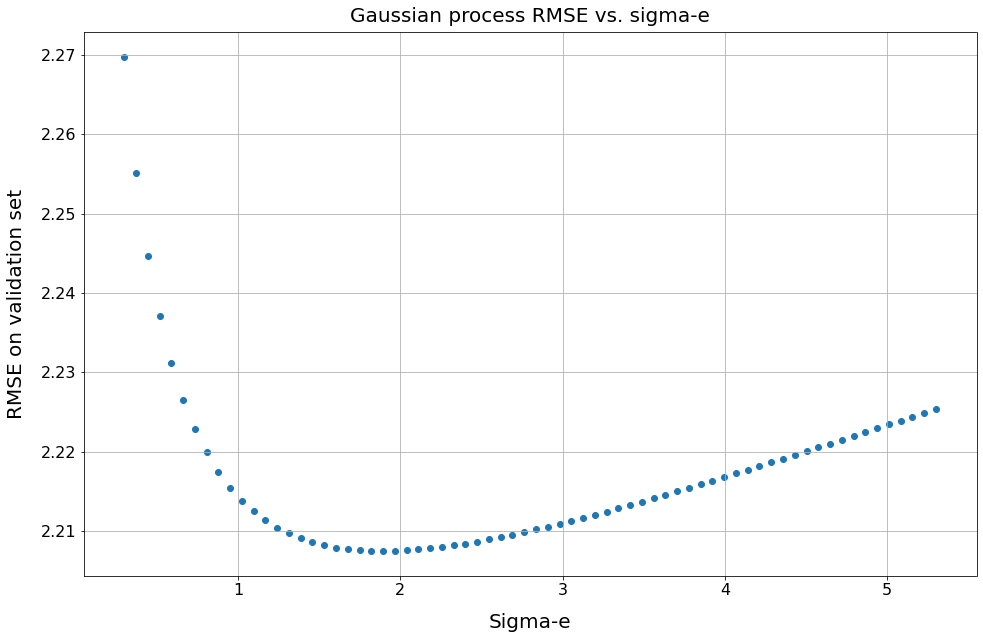

In [359]:
'''
fig, ax = plt.subplots(1,3, figsize=(20,4.5))
fig.subplots_adjust(wspace=0.1)
ax[0].set_ylabel('RMSE on validation set')
ax[0].set_xlabel('Length-Scale')
ax[0].scatter(l_list, rmse_list)
ax[1].set_xlabel('Sigma-f')
ax[1].scatter(sigma_f_list, rmse_list)
ax[2].set_xlabel('Sigma-e')
ax[2].scatter(sigma_e_list, rmse_list)
plt.show()

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('RMSE on validation set')
ax.set_ylabel('Sigma-f')
ax.set_xlabel('Length-Scale')
ax.scatter(xs=l_list, ys=sigma_f_list, zs=rmse_list, c=rmse_list, cmap='viridis')
#ax.plot_wireframe(X=np.array(l_list), Y=np.array(sigma_f_list), Z=np.array(rmse_list))
plt.show()
'''
fig = plt.figure(figsize=(16,10))
plt.ylabel('RMSE on validation set', fontsize=20, labelpad=15)
plt.xlabel('Sigma-e', fontsize=20, labelpad=15)
plt.title('Gaussian process RMSE vs. sigma-e', fontsize=20, pad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.scatter(sigma_e_list, rmse_list)
plt.savefig('GP_se_tuned.png', bbox_inches='tight')
plt.show()